In [9]:
# CSV preprocessing

import pandas as pd
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.pyplot as plt


dataset1 = pd.read_csv('Datasets/dataset_mobility.csv')

grouped_df = dataset1.groupby(['state', 'mobility_type']).agg({
    'x_time': list,
    'x_date': list,
    'y_ridership_change': list,
    'phase': list,
}).reset_index()

dataset1 = grouped_df
dataset1


def process_row(row):
    y_changes = list(row['y_ridership_change'])
    x_times = list(row['x_time'])
    phases = list(row['phase'])

    moving = [y_changes[i] != y_changes[i-1] for i in range(1, len(y_changes))]
    if any(moving):
        start_move = moving.index(True)
        end_move = len(moving) - 1 - moving[::-1].index(True)
        t0 = x_times[start_move]
        t3 = x_times[end_move]
    # Calculate t2
    min_index = y_changes.index(min(y_changes))
    t2 = x_times[min_index]

    index = 100
    # Smooth the y_changes using a moving average (you can adjust the window size), starting from t2
    smoothed_y_changes = y_changes.copy()
    smoothed_y_changes[index:] = uniform_filter1d(
        y_changes[index:], size=5)
    # plt.plot(smoothed_y_changes)
    # plt.show()
    # Determine the threshold for t3 (e.g., 5% change)
    threshold_change = 0.01  # Change this to 0.01 for 1% change
    # Number of consecutive points to check (adjust as needed)
    window_size = 15
    #t3 = None

    consecutive_count = 0
    for i in range(index + 1, len(smoothed_y_changes)):
        change = (
            smoothed_y_changes[i] - smoothed_y_changes[i-1]) / smoothed_y_changes[i-1]
        if abs(change) <= threshold_change:
            consecutive_count += 1
            if consecutive_count >= window_size:
                t3 = x_times[i]
                break
        else:
            consecutive_count = 0
    if t3 is not None:
        t3_index = x_times.index(t3)
        phases[t3_index:] = ['S'] * (len(phases) - t3_index)

    return pd.Series([t2, phases, t0, t3, row['x_time'], phases, row['y_ridership_change'], smoothed_y_changes])


# Apply function to DataFrame
dataset1[['t2', 'phase', 't0', 't3', 'x_time', 'phase',
          'y_ridership_change', 'smoothed']] = dataset1.apply(process_row, axis=1)

'''for mobility_type, group in dataset1.groupby('mobility_type'):
    # Iterate through each state within the mobility type
    for _, row in group.iterrows():
        x_time = row['x_time']
        smoothed_y_changes = row['smoothed']
        ridership_changes = row['y_ridership_change']
        t3 = row['t3'] - x_time[0]

        # Plot the trajectory
        plt.plot(ridership_changes, label='Trajectory')
        plt.plot(smoothed_y_changes)

        # Add red line at t3 if defined
        if t3 is not None:
            plt.axvline(x=t3, color='red', linestyle='--', label='t3')

        plt.title(f"Trajectory for {mobility_type} - State {row['state']}")
        plt.xlabel('Time')
        plt.ylabel('Ridership Change')
        plt.legend()
        plt.show()'''


C:\Users\Eddie\AppData\Local\Temp\ipykernel_34296\1344499452.py:52: RuntimeWarning: invalid value encountered in double_scalars
  change = (
C:\Users\Eddie\AppData\Local\Temp\ipykernel_34296\1344499452.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  change = (


'for mobility_type, group in dataset1.groupby(\'mobility_type\'):\n    # Iterate through each state within the mobility type\n    for _, row in group.iterrows():\n        x_time = row[\'x_time\']\n        smoothed_y_changes = row[\'smoothed\']\n        ridership_changes = row[\'y_ridership_change\']\n        t3 = row[\'t3\'] - x_time[0]\n\n        # Plot the trajectory\n        plt.plot(ridership_changes, label=\'Trajectory\')\n        plt.plot(smoothed_y_changes)\n\n        # Add red line at t3 if defined\n        if t3 is not None:\n            plt.axvline(x=t3, color=\'red\', linestyle=\'--\', label=\'t3\')\n\n        plt.title(f"Trajectory for {mobility_type} - State {row[\'state\']}")\n        plt.xlabel(\'Time\')\n        plt.ylabel(\'Ridership Change\')\n        plt.legend()\n        plt.show()'

In [10]:


# min max = current val - min val / Max val - min val
def minmax_normalize(lst):
    min_val, max_val = min(lst), max(lst)
    return [(x - min_val) / (max_val - min_val) for x in lst]


dataset1['y_ridership_change'] = dataset1['y_ridership_change'].apply(
    minmax_normalize)
dataset1['smoothed'] = dataset1['smoothed'].apply(
    minmax_normalize)
dataset1

# apply arbitrary threshold
threshold = 0.5
dataset1['capped_0.5'] = dataset1['y_ridership_change'].apply(
    lambda y: [min(value, threshold) for value in y])
threshold = 0.9
dataset1['capped_0.9'] = dataset1['y_ridership_change'].apply(
    lambda y: [min(value, threshold) for value in y])
threshold = 0.95
dataset1['capped_0.95'] = dataset1['y_ridership_change'].apply(
    lambda y: [min(value, threshold) for value in y])
dataset1


,state,mobility_type,x_time,x_date,y_ridership_change,phase,t2,t0,t3,smoothed,capped_0.5,capped_0.9,capped_0.95
0,Alabama,grocery_and_pharmacy_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.3480051608652516, 0.3480051608652516, 0.348...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",45034,44977,45060,"[0.3480051608652516, 0.3480051608652516, 0.348...","[0.3480051608652516, 0.3480051608652516, 0.348...","[0.3480051608652516, 0.3480051608652516, 0.348...","[0.3480051608652516, 0.3480051608652516, 0.348..."
1,Alabama,parks_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.16744391588245003, 0.16744391588245003, 0.1...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",45029,44977,45129,"[0.17204034678772934, 0.17204034678772934, 0.1...","[0.16744391588245003, 0.16744391588245003, 0.1...","[0.16744391588245003, 0.16744391588245003, 0.1...","[0.16744391588245003, 0.16744391588245003, 0.1..."
2,Alabama,residential_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.07410541316565529, 0.07410541316565529, 0.0...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",44988,44977,45077,"[0.07410541316565529, 0.07410541316565529, 0.0...","[0.07410541316565529, 0.07410541316565529, 0.0...","[0.07410541316565529, 0.07410541316565529, 0.0...","[0.07410541316565529, 0.07410541316565529, 0.0..."
3,Alabama,retail_and_recreation_percent_change_from_base...,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.7548346058213418, 0.7548346058213418, 0.754...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",45028,44977,45099,"[0.7548346058213418, 0.7548346058213418, 0.754...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.7548346058213418, 0.7548346058213418, 0.754...","[0.7548346058213418, 0.7548346058213418, 0.754..."
4,Alabama,transit_stations_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.7323365234229103, 0.7323365234229103, 0.732...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",45028,44977,45090,"[0.7323365234229103, 0.7323365234229103, 0.732...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.7323365234229103, 0.7323365234229103, 0.732...","[0.7323365234229103, 0.7323365234229103, 0.732..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,Wyoming,parks_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.06984255148519386, 0.06984255148519386, 0.0...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",45033,44977,45153,"[0.07095281844444082, 0.07095281844444082, 0.0...","[0.06984255148519386, 0.06984255148519386, 0.0...","[0.06984255148519386, 0.06984255148519386, 0.0...","[0.06984255148519386, 0.06984255148519386, 0.0..."
308,Wyoming,residential_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.07734806630186808, 0.07734806630186808, 0.0...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",44996,44977,45076,"[0.07734806630186808, 0.07734806630186808, 0.0...","[0.07734806630186808, 0.07734806630186808, 0.0...","[0.07734806630186808, 0.07734806630186808, 0.0...","[0.07734806630186808, 0.07734806630186808, 0.0..."
309,Wyoming,retail_and_recreation_percent_change_from_base...,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.7991493383515907, 0.7991493383515907, 0.799...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",45033,44977,45107,"[0.7991493383515907, 0.7991493383515907, 0.799...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.7991493383515907, 0.799149

['grocery_and_pharmacy_percent_change_from_baseline'
 'parks_percent_change_from_baseline'
 'residential_percent_change_from_baseline'
 'retail_and_recreation_percent_change_from_baseline'
 'transit_stations_percent_change_from_baseline'
 'workplaces_percent_change_from_baseline']


C:\Users\Eddie\AppData\Local\Temp\ipykernel_34296\565582591.py:67: RuntimeWarning: invalid value encountered in true_divide
  weighted_average_trajectory = cumulative_weighted_sum / total_population_array
C:\Users\Eddie\AppData\Local\Temp\ipykernel_34296\565582591.py:254: RuntimeWarning: Mean of empty slice
  return np.nanmean(data, axis=0)
C:\Users\Eddie\AppData\Local\Temp\ipykernel_34296\565582591.py:271: RuntimeWarning: invalid value encountered in true_divide
  avg_results4 = avg_results / avg_results2


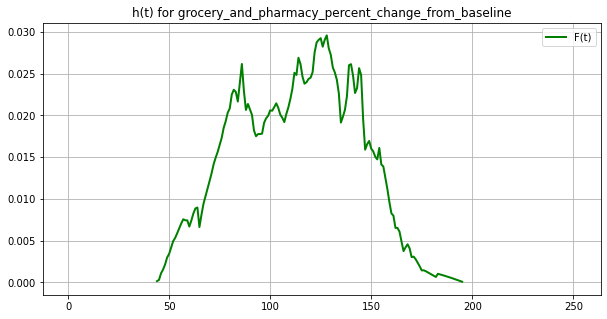

C:\Users\Eddie\AppData\Local\Temp\ipykernel_34296\565582591.py:118: RuntimeWarning: invalid value encountered in double_scalars
  alpha = (-6 * Qmax) / (t2 ** 3)


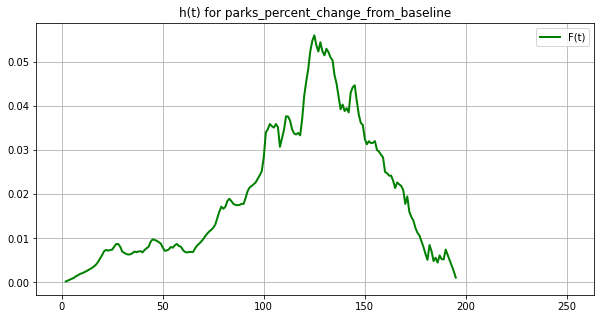

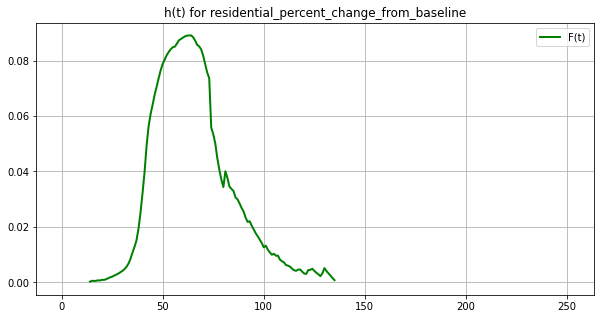

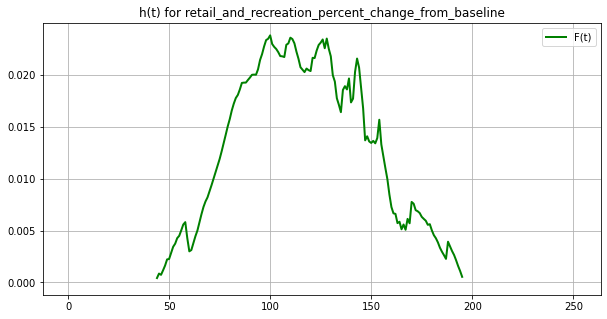

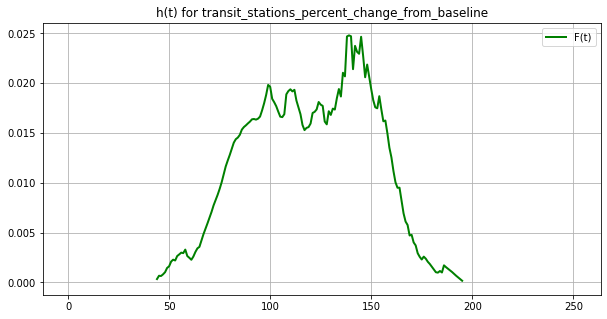

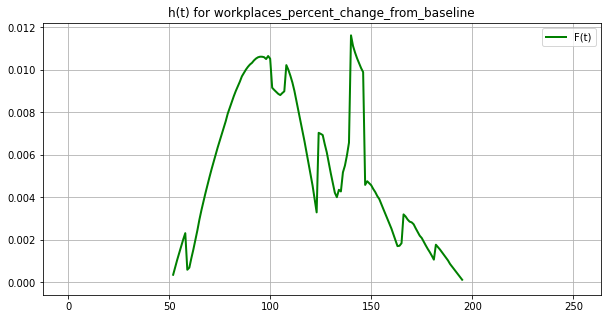

In [26]:
'''
Purpose of code is to

'''


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  # Import r2_score
from sklearn.metrics import mean_squared_error, r2_score

Qmax_values = {}
alpha_values = {}
beta_values = {}
delta_values = {}
initial_values = {}
df = pd.DataFrame()
res = []
df_long_format = pd.DataFrame(columns=['state', 'mobility_type'])

mobility_types = dataset1['mobility_type'].unique()
print(dataset1['mobility_type'].unique())
for mobility_type in mobility_types:
    dataset_filtered = dataset1[dataset1['mobility_type']
                                == mobility_type].reset_index(drop=True)

    def filter_values(row):
        phases = row['phase']
        ridership_changes = row['capped_0.9']
        date_values = row['x_date']  # Renaming this to date_values for clarity
        filtered_phases = []
        filtered_ridership_changes = []
        dates = []  # Reset for each row
        for phase, change, date_value in zip(phases, ridership_changes, date_values):
            if phase != 'S':
                filtered_phases.append(phase)
                filtered_ridership_changes.append(change)
                dates.append(date_value)  # Appending individual date value
        row['phase'] = filtered_phases
        row['y_ridership_change'] = filtered_ridership_changes
        row['x_date'] = dates

        return row

    dataset_filtered = dataset_filtered.apply(filter_values, axis=1)
    '''
    dataset2 = pd.read_csv('../../ExportedData/PopulationEstimates.csv')
    dataset3 = pd.read_csv('../../ExportedData/PopulationEstimates2.csv')

    dataset_filtered['Population'] = dataset2['Population']
    dataset_filtered['Pop Density'] = dataset3['Pop Density']
    dataset_filtered['sqmi'] = dataset3['sqmi']

    max_length = max(len(x) for x in dataset_filtered['y_ridership_change'])

    cumulative_weighted_sum = np.zeros(max_length)
    total_population_array = np.zeros(max_length)

    for i in range(len(dataset_filtered)):
        queue_data = np.array(dataset_filtered['y_ridership_change'][i])
        population = float(dataset_filtered['Population'][i])
        for j in range(len(queue_data)):
            cumulative_weighted_sum[j] += queue_data[j] * population
            total_population_array[j] += population'''

    weighted_average_trajectory = cumulative_weighted_sum / total_population_array
    weighted_average_trajectory_f = weighted_average_trajectory[:150]
    time_index_of_min_weighted_average = np.argmin(weighted_average_trajectory)
    time_index_of_min_weighted_average_f = np.argmin(
        weighted_average_trajectory_f)

    # plt.show()
    min_weighted_average_value = weighted_average_trajectory[time_index_of_min_weighted_average]

    all_results = []
    all_results2 = []
    all_results0 = []
    all_t2s = []
    all_t4s = []
    all_results4 = []
    all_results_collection = []
    all_results2_collection = []
    all_results0_collection = []
    all_results1_collection = []
    for i in range(len(dataset_filtered)):
        state = dataset_filtered['state'][i]
        x_date = np.array(dataset_filtered['x_date'][i])
        queue_data = np.array(dataset_filtered['y_ridership_change'][i])
        deviation = queue_data[:len(
            weighted_average_trajectory)] - weighted_average_trajectory[:len(queue_data)]

        time_index_of_min_weighted_average_f = np.argmin(
            queue_data)
        t4 = len(deviation) - 1
        # dataset_filtered['t3'][i]
        t2 = time_index_of_min_weighted_average_f

        queue_data = queue_data[:t4+1]
        '''weighted_average_trajectory_f = weighted_average_trajectory[:t4+1]

        Queue_Delta = weighted_average_trajectory_f[-1]

        initial_weighted_average = weighted_average_trajectory[0]

        def linear_interpolation(t):
            slope = (Queue_Delta) / (t4)
            return initial_weighted_average + slope * t

        # Calculate the interpolated values
        interpolated_values = [linear_interpolation(
            t) for t in range(len(weighted_average_trajectory_f))]'''

        Qmax = queue_data[time_index_of_min_weighted_average_f]

        initial = queue_data[1]
        Delta = queue_data[-1]
        alpha = (-6 * Qmax) / (t2 ** 3)
        beta = (6 * (Qmax - Delta)) / ((t4 - t2) ** 3)
        # Calculate Qmax, alpha, beta, etc. using modified_deviation

        Qmax_values[(mobility_type, i)] = Qmax
        alpha_values[(mobility_type, i)] = alpha
        beta_values[(mobility_type, i)] = beta
        initial_values[(mobility_type, i)] = initial
        delta_values[(mobility_type, i)] = Delta

        t0 = 0

        def deviation_polynomial(t):
            if t0 < t <= t2:
                return alpha * (t - t0) * (t - t2)
            elif t2 < t <= t4:
                return beta * (t - t2) * (t - t4)
            else:
                return 0

        deviation_polynomial_values = [
            deviation_polynomial(t) for t in range(len(queue_data))]

        # V(t)/1-F(t)
        # F(t) Trajcetory

        def modified_quadratic_function(t, alpha, t0, t2):
            term1 = (t - t0) ** 2
            term2 = ((t2 - t0) / 2) - ((t - t0) / 3)
            return -(alpha * term1) * term2

        def quadratic_function(t, Qmax, beta, t2, t4):
            term1 = (t - t2) ** 2
            term2 = ((t4 - t2) / 2) - ((t - t2) / 3)
            return Qmax - (beta * term1) * term2

        quadratic_values_t0_t2 = [modified_quadratic_function(
            t, alpha, t0, t2) for t in range(t0, t2)]
        quadratic_values_t2_t4 = [quadratic_function(
            t, Qmax, beta, t2, t4) for t in range(t2, t4+1)]
        quadratic_values_combined = quadratic_values_t0_t2 + quadratic_values_t2_t4

        # Your preprocessing or prior code...

        try:
            run_count += 1
        except NameError:
            run_count = 1

        # Create an array of zeros up to t2
        h_t_prefix = np.full(t2, np.nan)

        # Calculate the values using the given formula from t2 to t4 for result
        h_t_suffix = deviation_polynomial_values[t2:t4+1] / (
            1 - np.array(queue_data[t2:t4+1]))
        h_t = np.concatenate((h_t_prefix, h_t_suffix))

        # For result1
        f_t_suffix = deviation_polynomial_values[t2:t4+1]
        f_t = np.concatenate((h_t_prefix, f_t_suffix))

        # For result2
        S_t_suffix = 1 - np.array(queue_data[t2:t4+1])
        S_t = np.concatenate((h_t_prefix, S_t_suffix))

        # For result3
        F_t_suffix = np.array(queue_data[t2:t4+1])
        F_t = np.concatenate((h_t_prefix, F_t_suffix))

        # Determine how many zeros to append
        num_zeros_to_append = 250 - len(h_t)
        # Append the NaN values
        h_t = np.concatenate((h_t, np.full(num_zeros_to_append, np.nan)))
        f_t = np.concatenate(
            (f_t, np.full(num_zeros_to_append, np.nan)))
        S_t = np.concatenate(
            (S_t, np.full(num_zeros_to_append, np.nan)))
        F_t = np.concatenate(
            (F_t, np.full(num_zeros_to_append, np.nan)))
        date_prefix = [np.nan] * t2
        x_date_padded = np.concatenate(
            (date_prefix, x_date[t2:t4+1], np.full(num_zeros_to_append, np.nan)))
        all_results = deviation_polynomial_values[t2:t4+1]
        all_results2 = 1 - np.array(queue_data[t2:t4+1])
        all_results0 = np.array(queue_data[t2:t4+1])
        all_results_collection.append(deviation_polynomial_values[t2:t4+1])
        all_results2_collection.append((1 - queue_data[t2:t4+1]))
        all_results0_collection.append(queue_data[t2:t4+1])
        all_results1_collection.append(h_t)
        # Generate a new column name for each run
        column_name = f"h(t): {state} {mobility_type}"
        # If df has more rows than average_result3, pad average_result3 with NaN

        #df[column_name] = h_t
        temp_df = pd.DataFrame({
            'state': [state] * len(h_t),
            'mobility_type': [mobility_type] * len(h_t),
            "t": np.arange(len(h_t)),
            "date": x_date_padded,
            'h(t)': h_t,
            'f(t)': f_t,
            'S(t)': S_t,
            'F(t)': F_t,
            'Qmax': [Qmax] * len(h_t),
            'Delta': [Delta] * len(h_t)
        })

        # Append the temporary DataFrame to the main long format DataFrame
        df_long_format = pd.concat(
            [df_long_format, temp_df], ignore_index=True)
        all_t2s.append(t2)
        all_t4s.append(t4)

    def align_and_normalize_with_zero_padding(data):
        # Determine the maximum length
        max_length = max([len(item) for item in data])

        # Align and normalize data
        normalized_data = []
        for item in data:
            # Convert numpy array to list and replace zeros with NaNs
            item_list = item.tolist() if isinstance(item, np.ndarray) else item
            item_list = [np.nan if x == 0 else x for x in item_list]

            # Prepend NaNs for alignment
            aligned = [np.nan] * (max_length - len(item_list)) + item_list

            # Add zero to the beginning and end
            aligned = [0] + aligned + [0]

            normalized_data.append(aligned)

        return normalized_data

    def compute_average(data):
        data = np.array(data)
        return np.nanmean(data, axis=0)

    # Align and normalize
    all_results_collection = align_and_normalize_with_zero_padding(
        all_results_collection)
    all_results2_collection = align_and_normalize_with_zero_padding(
        all_results2_collection)
    all_results0_collection = align_and_normalize_with_zero_padding(
        all_results0_collection)
    all_results1_collection = align_and_normalize_with_zero_padding(
        all_results1_collection)
    # Compute average
    avg_results = compute_average(all_results_collection)
    avg_results2 = compute_average(all_results2_collection)
    avg_results0 = compute_average(all_results0_collection)
    avg_results1 = compute_average(all_results1_collection)

    avg_results4 = avg_results / avg_results2
    res.append(avg_results1)

    plt.figure(figsize=[10, 5])
    plt.plot(avg_results1, linewidth=2, color='green',
             label='F(t)')
    plt.title(f"h(t) for {mobility_type}")
    plt.legend()
    plt.grid()
    plt.savefig(f'h(t) {mobility_type}.jpg')
    plt.show()

    # plt.plot(weighted_average_trajector
res_transposed = list(zip(*res))
df2 = pd.DataFrame(res_transposed, columns=dataset1['mobility_type'].unique())
df2.to_csv('h(t)_by_mobility_type.csv')
df_long_format.to_csv('h(t)_2_by_state.csv')


# Work in Progress (no need to implement, in fact, remove if needed)

In [50]:
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

import pandas as pd

# Read the CSV file with your main data
path_deviation = "../../ExportedData/DeviationDF.csv"
deviation_df = pd.read_csv(path_deviation)

# Read the state centroids data from a CSV file
path_centroids = "../../StateCentroids.csv"  # Change to the correct path
centroids_df = pd.read_csv(path_centroids)

# Rename the "state" column in deviation_df to "name" for proper merging
deviation_df.rename(columns={'state': 'name'}, inplace=True)

# Merge the deviation DataFrame with the centroids DataFrame on the "name" column
final_df = pd.merge(deviation_df, centroids_df, on='name', how='left')

# Now final_df contains the data for each state and mobility type, along with the corresponding centroids
final_df
final_df = final_df.dropna(subset=['latitude', 'longitude'])

final_df.to_csv('final.csv')


KeyboardInterrupt: 

In [785]:
from sklearn.preprocessing import MinMaxScaler

# Specify the columns you want to scale
columns_to_scale = ['population', 'popsqmi',
                    'Qmax', 'alpha', 'beta', 'initial', 'delta']

# Get unique mobility types
mobility_types = final_df['mobility_type'].unique()

# Instantiate the scaler
scaler = MinMaxScaler()

# Apply the scaler separately for each mobility type
for mobility_type in mobility_types:
    subset = final_df[final_df['mobility_type'] == mobility_type]
    scaled_values = scaler.fit_transform(subset[columns_to_scale])
    final_df.loc[final_df['mobility_type'] ==
                 mobility_type, columns_to_scale] = scaled_values

# Now final_df contains the scaled values, applied separately for each mobility type
final_df


,Unnamed: 0,name,mobility_type,population,popsqmi,sqmi,Qmax,alpha,beta,initial,delta,state,latitude,longitude
0,0,Alabama,retail_and_recreation_percent_change_from_base...,0.114422,0.008669,50645,0.697879,0.456681,0.706094,0.343696,0.763775,AL,32.318231,-86.902298
1,1,Alaska,retail_and_recreation_percent_change_from_base...,0.003990,0.000000,570641,0.701688,0.453715,0.345163,0.503976,0.944243,AK,63.588753,-154.493062
2,2,Arizona,retail_and_recreation_percent_change_from_base...,0.169621,0.005463,113594,0.663135,0.483730,0.792151,0.805182,0.647163,AZ,34.048928,-111.093731
3,3,Arkansas,retail_and_recreation_percent_change_from_base...,0.062599,0.005012,52035,1.000000,0.221471,0.578141,0.500852,0.863153,AR,35.201050,-91.831833
4,4,California,retail_and_recreation_percent_change_from_base...,1.000000,0.022375,"155,959[4]",0.556092,0.567066,0.872638,0.636474,0.457614,CA,36.778261,-119.417932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,307,Virginia,residential_percent_change_from_baseline,0.207041,0.019276,39490,0.927367,0.504463,0.000115,0.653153,1.000000,VA,37.431573,-78.656894
308,308,Washington,residential_percent_change_from_baseline,0.183599,0.010156,66456,0.978883,0.278297,0.000387,0.159682,0.382515,WA,47.751074,-120.740139
309,309,West Virginia,residential_percent_change_from_baseline,0.031184,0.006490,24038,0.820114,0.712675,0.000991,0.335233,0.294528,WV,38.597626,-80.454903
310,310,Wisconsin,residential_percent_change_from_baseline,0.136642,0.009536,54158,0.887613,0.528005,0.000447,0.139965,0.750541,WI,43.784440,-88.787868


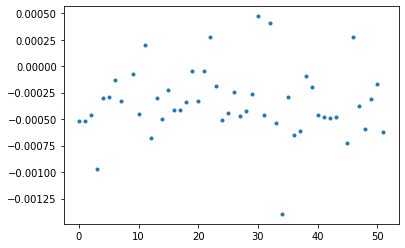

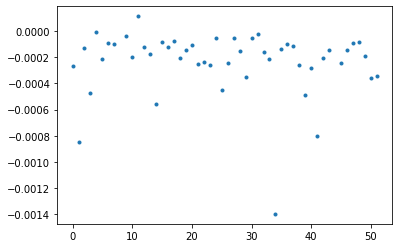

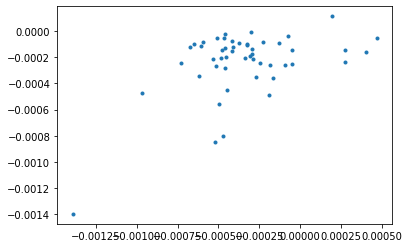

In [787]:
final_df1 = final_df[final_df['mobility_type'] ==
                     'retail_and_recreation_percent_change_from_baseline']
final_df1 = final_df1[final_df1['state'] != 'US']
final_df1 = final_df1[final_df1['state']
                      != 'District of Columbia']


final_df1 = final_df1[final_df1['popsqmi'] < 10000]

plt.plot(final_df1['alpha'], '.')
plt.show()

plt.plot(final_df1['beta'], '.')
plt.show()
plt.plot(final_df1['alpha'], final_df1['beta'], '.')
plt.show()


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[45. 43. 50.] [43. 43. 43.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Results for retail_and_recreation_percent_change_from_baseline - Beta:
Model type                                                         Gaussian
Number of observations:                                                  51
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.000
Log-likelihood:                                                     354.343
AIC:                                                               -702.686
AICc:                                                              -699.816
BIC:                                                               -188.728
R2:                                                                   0.130
Adj. R2:                                                              0.094

Variable                              Est.         SE  t(Est/SE) 

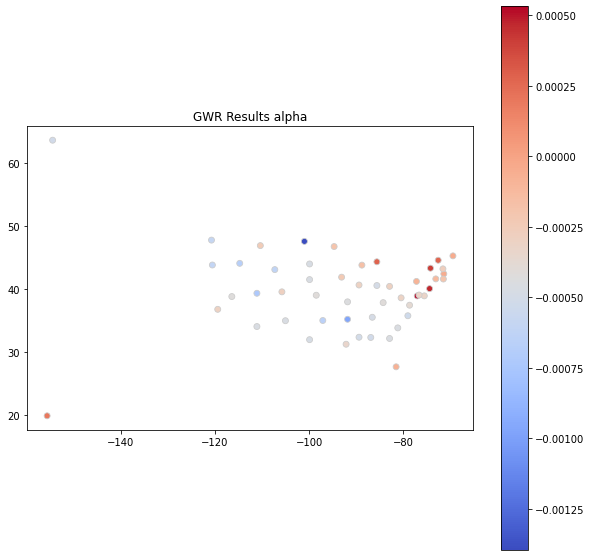

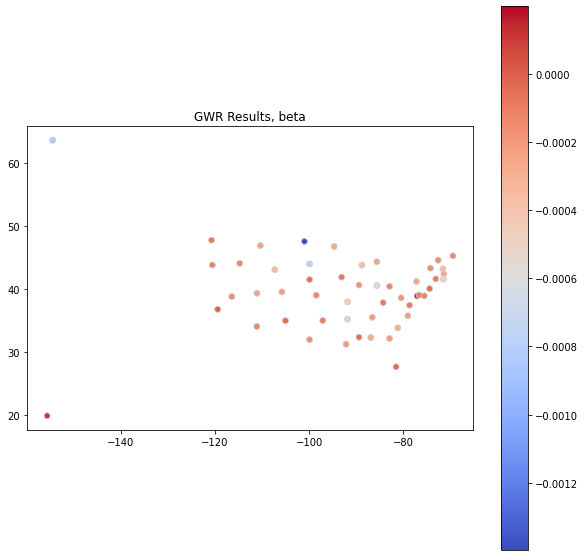

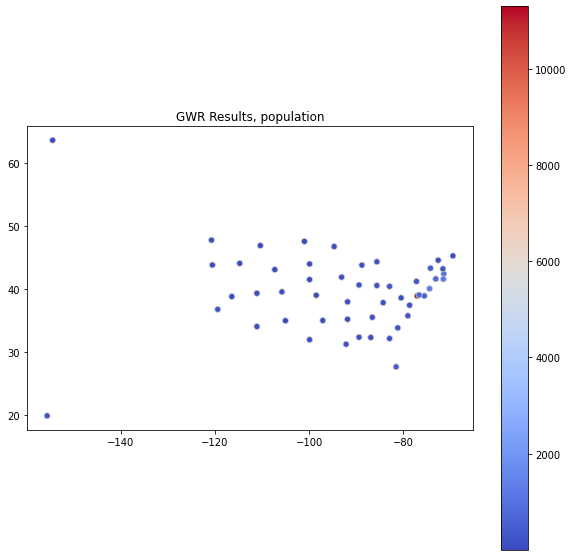

0        99.2
1         1.3
2        63.0
3        57.9
4       254.0
5        55.7
6       745.0
7       508.0
8     11295.0
9       402.0
10      186.0
11      227.0
12       22.3
13      231.0
14      189.0
15       57.1
16       35.9
17      114.0
18      108.0
19       44.2
20      636.0
21      901.0
22      178.0
23       71.7
24       63.1
25       89.5
26        7.5
27       25.5
28       28.3
29      154.0
30     1263.0
31       17.5
32      429.0
33      215.0
34       11.3
35      289.0
36       57.7
37       44.1
38      291.0
39     1061.0
40      170.0
41       11.7
42      168.0
43      112.0
45       39.8
46       69.8
47      219.0
48      116.0
49       74.6
50      109.0
51        5.9
Name: popsqmi, dtype: float64


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[43. 50. 50.] [43. 43. 50.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Results for grocery_and_pharmacy_percent_change_from_baseline - Beta:
Model type                                                         Gaussian
Number of observations:                                                  51
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.000
Log-likelihood:                                                     303.052
AIC:                                                               -600.105
AICc:                                                              -597.235
BIC:                                                               -188.728
R2:                                                                   0.062
Adj. R2:                                                              0.023

Variable                              Est.         SE  t(Est/SE)  

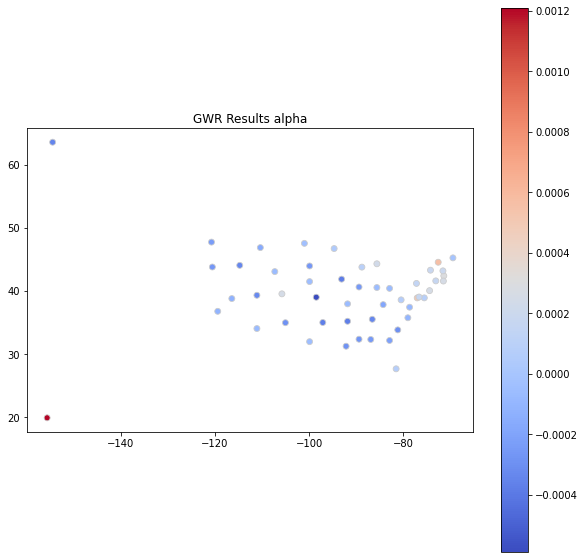

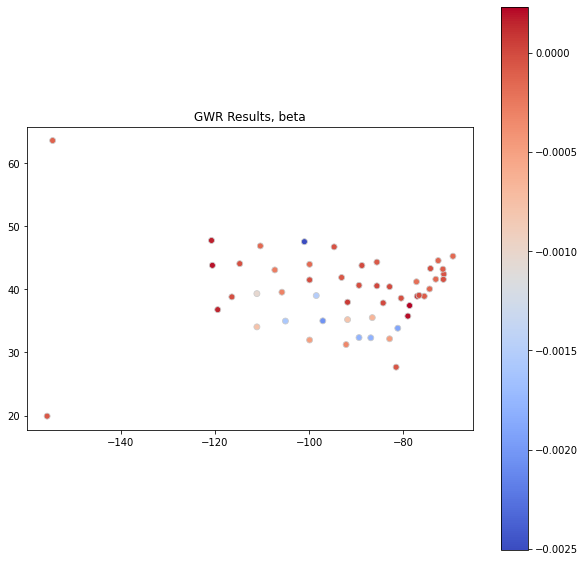

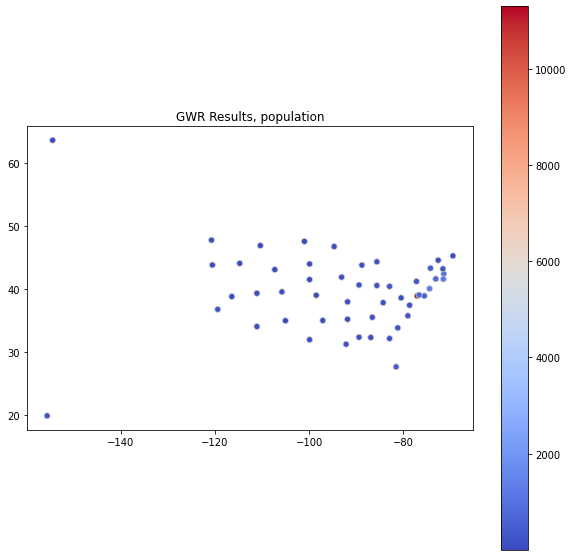

52        99.2
53         1.3
54        63.0
55        57.9
56       254.0
57        55.7
58       745.0
59       508.0
60     11295.0
61       402.0
62       186.0
63       227.0
64        22.3
65       231.0
66       189.0
67        57.1
68        35.9
69       114.0
70       108.0
71        44.2
72       636.0
73       901.0
74       178.0
75        71.7
76        63.1
77        89.5
78         7.5
79        25.5
80        28.3
81       154.0
82      1263.0
83        17.5
84       429.0
85       215.0
86        11.3
87       289.0
88        57.7
89        44.1
90       291.0
91      1061.0
92       170.0
93        11.7
94       168.0
95       112.0
97        39.8
98        69.8
99       219.0
100      116.0
101       74.6
102      109.0
103        5.9
Name: popsqmi, dtype: float64


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[50. 50. 50.] [43. 43. 43.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Results for parks_percent_change_from_baseline - Beta:
Model type                                                         Gaussian
Number of observations:                                                  51
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           5096.991
Log-likelihood:                                                    -189.783
AIC:                                                                385.565
AICc:                                                               388.435
BIC:                                                               4908.263
R2:                                                                   0.002
Adj. R2:                                                             -0.040

Variable                              Est.         SE  t(Est/SE)    p-value
-----

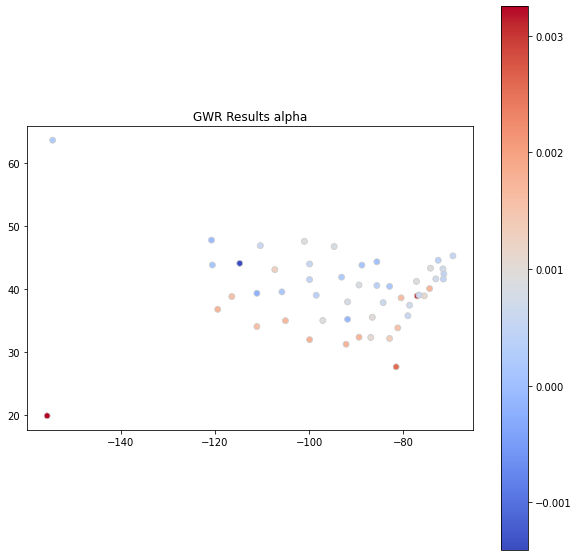

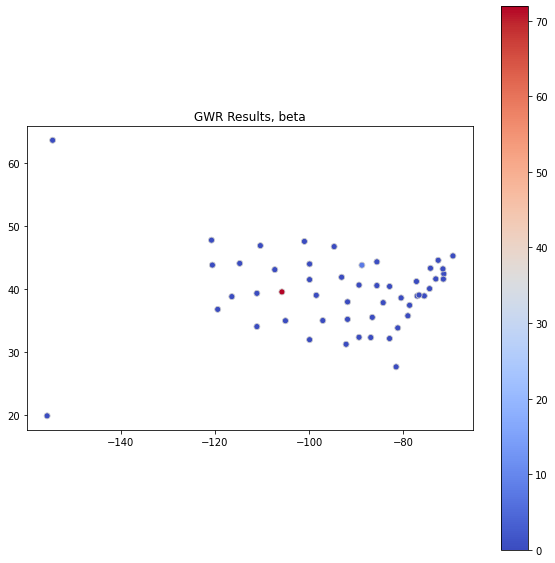

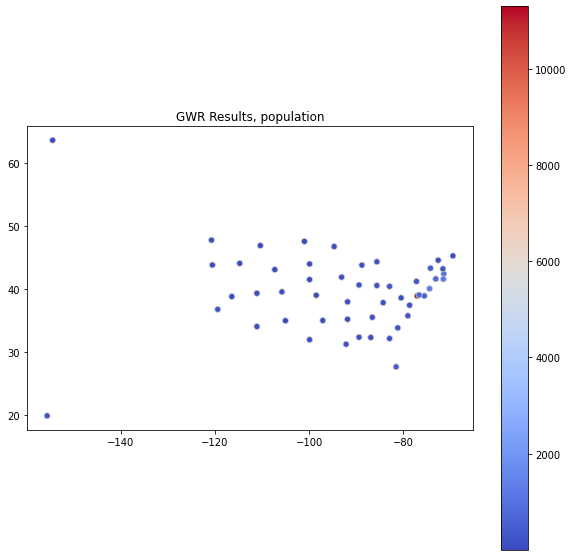

104       99.2
105        1.3
106       63.0
107       57.9
108      254.0
109       55.7
110      745.0
111      508.0
112    11295.0
113      402.0
114      186.0
115      227.0
116       22.3
117      231.0
118      189.0
119       57.1
120       35.9
121      114.0
122      108.0
123       44.2
124      636.0
125      901.0
126      178.0
127       71.7
128       63.1
129       89.5
130        7.5
131       25.5
132       28.3
133      154.0
134     1263.0
135       17.5
136      429.0
137      215.0
138       11.3
139      289.0
140       57.7
141       44.1
142      291.0
143     1061.0
144      170.0
145       11.7
146      168.0
147      112.0
149       39.8
150       69.8
151      219.0
152      116.0
153       74.6
154      109.0
155        5.9
Name: popsqmi, dtype: float64


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[50. 43. 50.] [43. 43. 50.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Results for transit_stations_percent_change_from_baseline - Beta:
Model type                                                         Gaussian
Number of observations:                                                  51
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.000
Log-likelihood:                                                     363.563
AIC:                                                               -721.126
AICc:                                                              -718.257
BIC:                                                               -188.728
R2:                                                                   0.115
Adj. R2:                                                              0.078

Variable                              Est.         SE  t(Est/SE)    p-

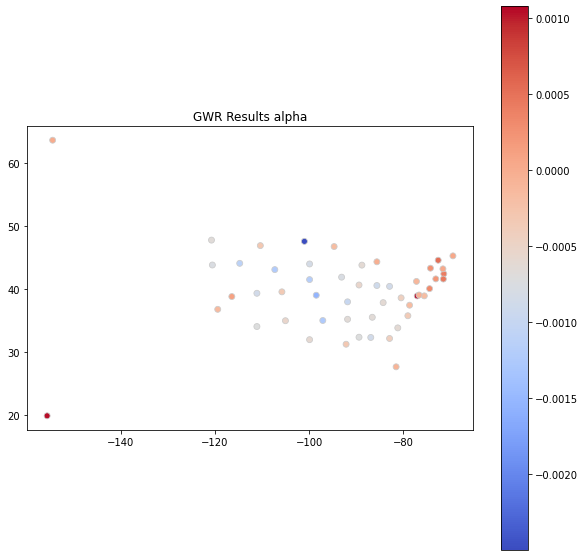

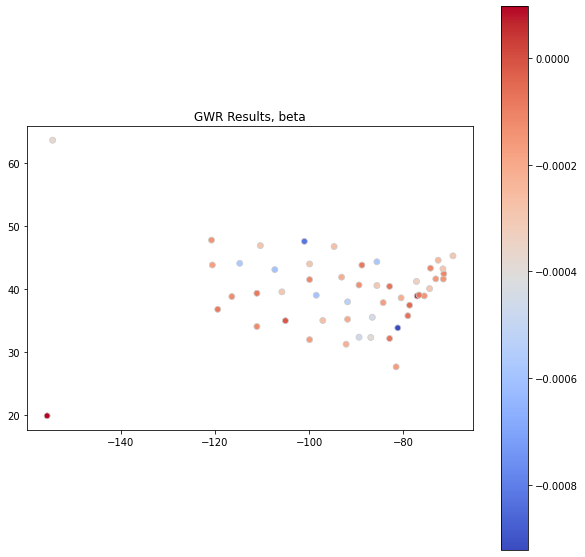

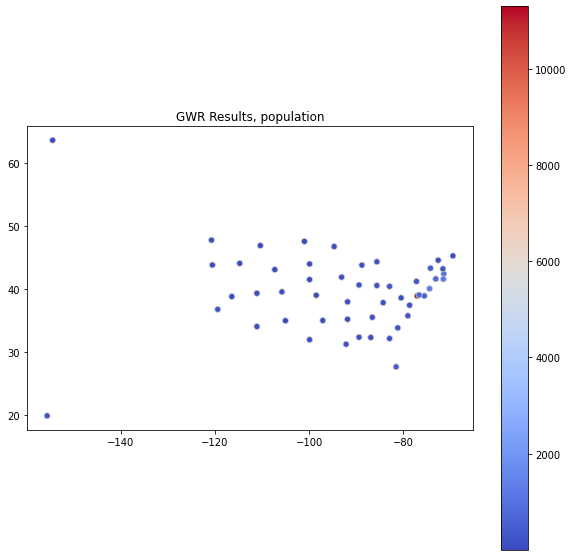

156       99.2
157        1.3
158       63.0
159       57.9
160      254.0
161       55.7
162      745.0
163      508.0
164    11295.0
165      402.0
166      186.0
167      227.0
168       22.3
169      231.0
170      189.0
171       57.1
172       35.9
173      114.0
174      108.0
175       44.2
176      636.0
177      901.0
178      178.0
179       71.7
180       63.1
181       89.5
182        7.5
183       25.5
184       28.3
185      154.0
186     1263.0
187       17.5
188      429.0
189      215.0
190       11.3
191      289.0
192       57.7
193       44.1
194      291.0
195     1061.0
196      170.0
197       11.7
198      168.0
199      112.0
201       39.8
202       69.8
203      219.0
204      116.0
205       74.6
206      109.0
207        5.9
Name: popsqmi, dtype: float64


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[45. 50. 50.] [43. 43. 43.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Results for workplaces_percent_change_from_baseline - Beta:
Model type                                                         Gaussian
Number of observations:                                                  51
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.000
Log-likelihood:                                                     364.212
AIC:                                                               -722.424
AICc:                                                              -719.554
BIC:                                                               -188.728
R2:                                                                   0.003
Adj. R2:                                                             -0.039

Variable                              Est.         SE  t(Est/SE)    p-value


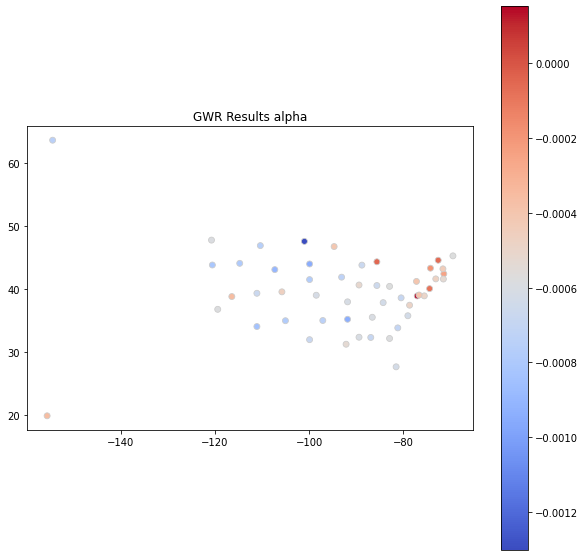

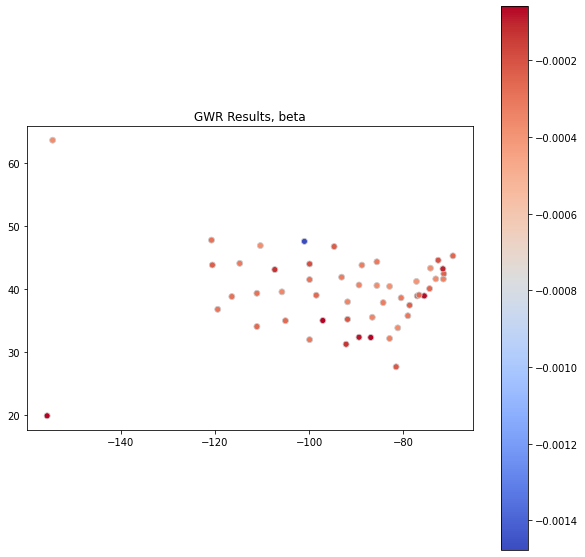

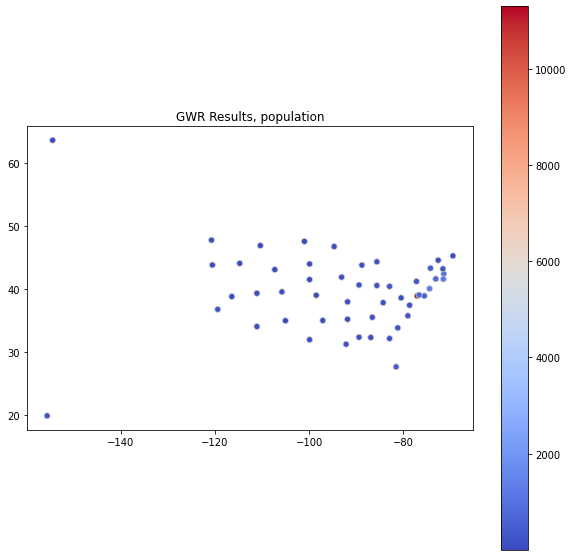

208       99.2
209        1.3
210       63.0
211       57.9
212      254.0
213       55.7
214      745.0
215      508.0
216    11295.0
217      402.0
218      186.0
219      227.0
220       22.3
221      231.0
222      189.0
223       57.1
224       35.9
225      114.0
226      108.0
227       44.2
228      636.0
229      901.0
230      178.0
231       71.7
232       63.1
233       89.5
234        7.5
235       25.5
236       28.3
237      154.0
238     1263.0
239       17.5
240      429.0
241      215.0
242       11.3
243      289.0
244       57.7
245       44.1
246      291.0
247     1061.0
248      170.0
249       11.7
250      168.0
251      112.0
253       39.8
254       69.8
255      219.0
256      116.0
257       74.6
258      109.0
259        5.9
Name: popsqmi, dtype: float64


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

[43. 48. 44.] [43. 43. 43.]


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Results for residential_percent_change_from_baseline - Beta:
Model type                                                         Gaussian
Number of observations:                                                  51
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              0.000
Log-likelihood:                                                     230.165
AIC:                                                               -454.331
AICc:                                                              -451.461
BIC:                                                               -188.727
R2:                                                                   0.971
Adj. R2:                                                              0.970

Variable                              Est.         SE  t(Est/SE)    p-value

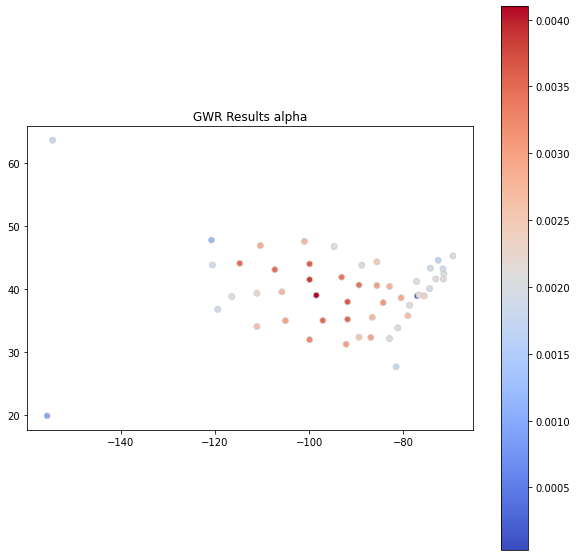

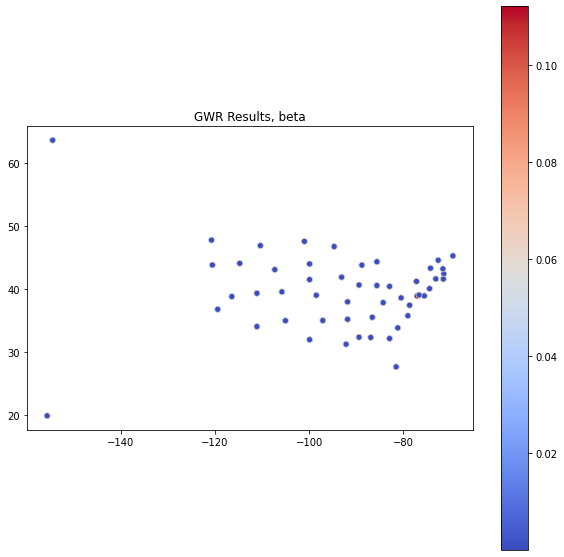

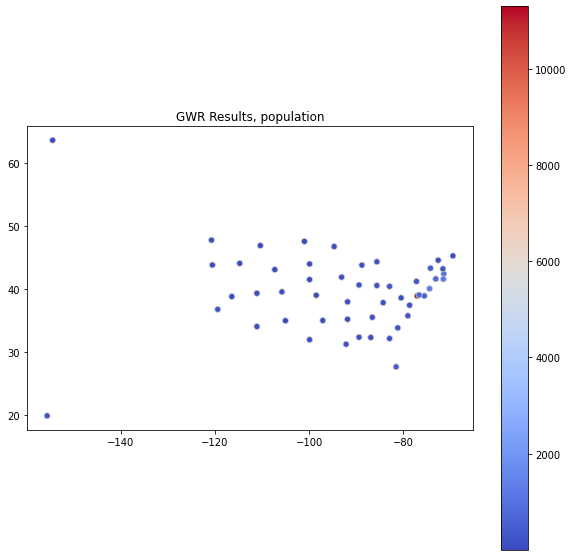

260       99.2
261        1.3
262       63.0
263       57.9
264      254.0
265       55.7
266      745.0
267      508.0
268    11295.0
269      402.0
270      186.0
271      227.0
272       22.3
273      231.0
274      189.0
275       57.1
276       35.9
277      114.0
278      108.0
279       44.2
280      636.0
281      901.0
282      178.0
283       71.7
284       63.1
285       89.5
286        7.5
287       25.5
288       28.3
289      154.0
290     1263.0
291       17.5
292      429.0
293      215.0
294       11.3
295      289.0
296       57.7
297       44.1
298      291.0
299     1061.0
300      170.0
301       11.7
302      168.0
303      112.0
305       39.8
306       69.8
307      219.0
308      116.0
309       74.6
310      109.0
311        5.9
Name: popsqmi, dtype: float64


In [791]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import MGWR
from scipy.stats import t

# Read the CSV file with your main data
# Your existing code
path_deviation = "../../ExportedData/DeviationDF.csv"
deviation_df = pd.read_csv(path_deviation)
path_centroids = "../../StateCentroids.csv"
centroids_df = pd.read_csv(path_centroids)
deviation_df.rename(columns={'state': 'name'}, inplace=True)
#final_df = pd.merge(deviation_df, centroids_df, on='name', how='left')
#final_df = final_df.dropna(subset=['latitude', 'longitude'])

# Create a GeoSeries from the latitude and longitude
geometry = [Point(xy) for xy in zip(final_df.longitude, final_df.latitude)]

# Convert to GeoDataFrame, specifying the coordinate reference system (CRS) if known
final_gdf = gpd.GeoDataFrame(final_df, geometry=geometry)

# If you know the CRS (e.g., EPSG:4326 for WGS84), you can set it
final_gdf.crs = "EPSG:4326"

# Extract unique mobility types
mobility_types = final_df['mobility_type'].unique()

for mobility_type in mobility_types:
    df_filtered = final_gdf[final_gdf['mobility_type'] == mobility_type]
    df_filtered = df_filtered[df_filtered['state']
                              != 'District of Columbia']
    # Define the independent variables
    X = df_filtered[['popsqmi', 'population']].values
    # Define the dependent variables (alpha, beta, etc.)
    y_alpha = df_filtered[['alpha']].values
    y_beta = df_filtered[['beta']].values

    # Define the coordinates (using latitude and longitude from the DataFrame)
    coords = list(zip(df_filtered['latitude'], df_filtered['longitude']))

    # Define the bandwidth
    sel_bw_alpha = Sel_BW(coords, y_alpha, X, multi=True)
    bw_alpha = sel_bw_alpha.search()
    sel_bw_beta = Sel_BW(coords, y_beta, X, multi=True)
    bw_beta = sel_bw_beta.search()

    print(bw_beta, bw_alpha)
    # Run GWR for alpha
    model_alpha = MGWR(coords, y_alpha, X, sel_bw_alpha)
    results_alpha = model_alpha.fit()
    r2_alpha = results_alpha.R2

    #print(f"Results for {mobility_type} - Alpha:")
    # print(results_alpha.summary())

    # Run GWR for beta
    model_beta = MGWR(coords, y_beta, X, sel_bw_beta)
    results_beta = model_beta.fit()
    print(f"Results for {mobility_type} - Beta:")
    print(results_beta.summary())
    t_values_alpha = results_alpha.filter_tvals()
    t_values_beta = results_beta.filter_tvals()

    # Get the number of observations
    n_observations = len(df_filtered)

    # Degrees of freedom (assuming two parameters including intercept)
    degrees_of_freedom = n_observations - 2

    # Critical t-value for 95% confidence level
    critical_t_value = t.ppf(0.95, degrees_of_freedom)

    # Find how many t-values are greater than the critical t-value in absolute terms
    # Assuming you're interested in the t-values for the covariate (not the intercept), you might want to consider only the second column
    significant_count_alpha = (
        np.abs(t_values_alpha[:, 1]) > critical_t_value).sum()
    significant_count_beta = (
        np.abs(t_values_beta[:, 1]) > critical_t_value).sum()
    print(np.abs(t_values_beta[:, 1]))
    print(np.abs(t_values_alpha[:, 1]))

    print(f"{significant_count_alpha} data points pass the 95% confidence level for alpha.")
    print(f"{significant_count_beta} data points pass the 95% confidence level for beta.")
    df_filtered['gwr_alpha'] = results_alpha.params[:, 1]
    '''df_filtered['R2'] = results_alpha.localR2
    df_filtered.plot('R2', legend=True)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig('local_R2')
    plt.show()'''

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    df_filtered.plot(column='alpha', cmap='coolwarm',
                     linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.title('GWR Results alpha')
    plt.show()
    fig, ax = plt.subplots(figsize=(10, 10))

    df_filtered.plot(column='beta', cmap='coolwarm',
                     linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.title('GWR Results, beta')
    plt.show()
    fig, ax = plt.subplots(figsize=(10, 10))

    df_filtered.plot(column='popsqmi', cmap='coolwarm',
                     linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.title('GWR Results, population')
    plt.show()
    print(df_filtered['popsqmi'])
# ... rest of the code for plotting


Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - Qmax with popsqmi:
48 out of 51 data points are significant (94.12%).


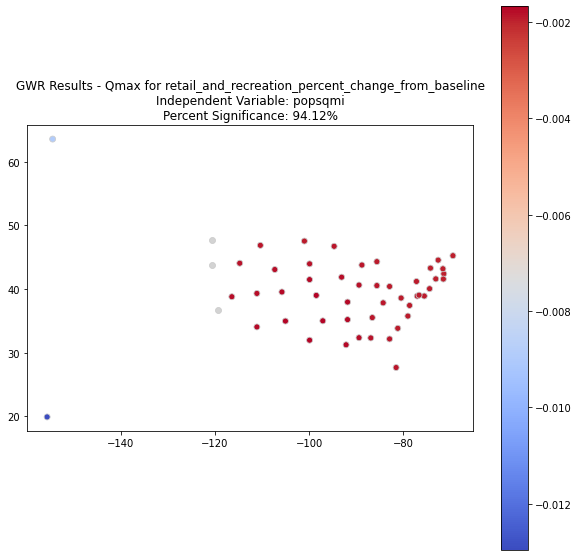

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - Qmax with population:
0 out of 51 data points are significant (0.00%).


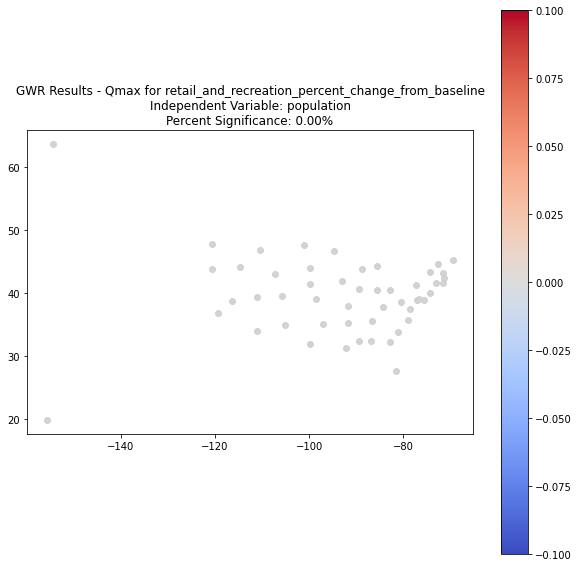

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - alpha with popsqmi:
48 out of 51 data points are significant (94.12%).


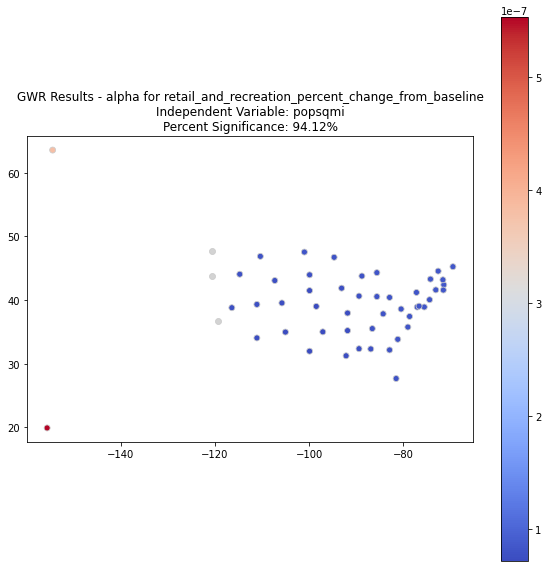

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - alpha with population:
0 out of 51 data points are significant (0.00%).


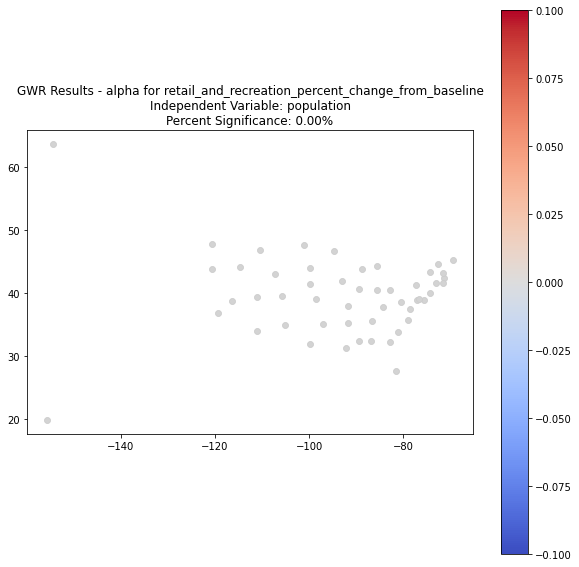

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - beta with popsqmi:
9 out of 51 data points are significant (17.65%).


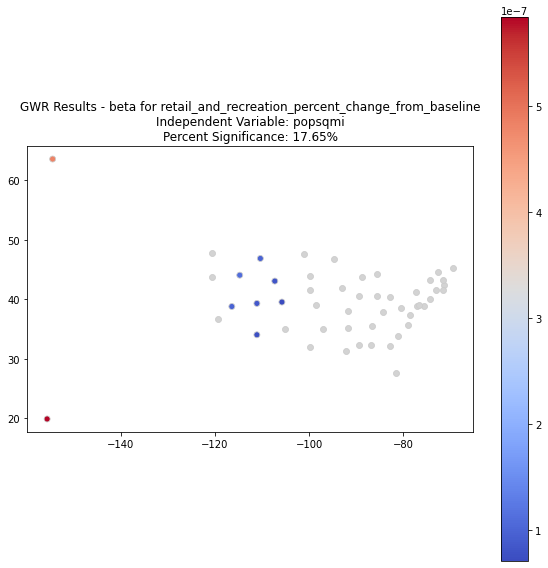

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - beta with population:
0 out of 51 data points are significant (0.00%).


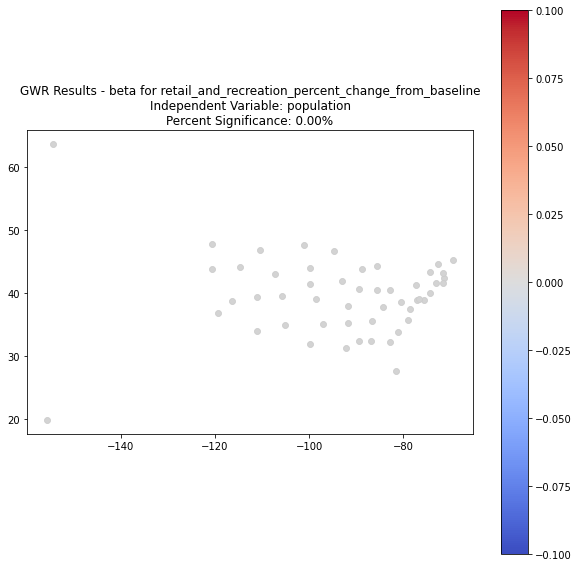

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - initial with popsqmi:
0 out of 51 data points are significant (0.00%).


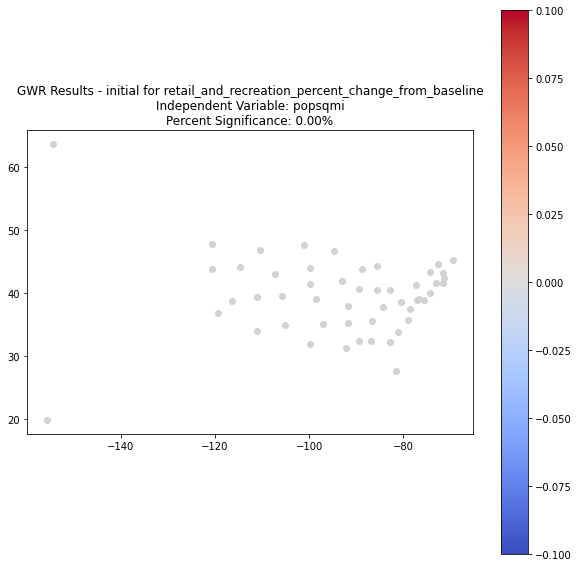

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - initial with population:
0 out of 51 data points are significant (0.00%).


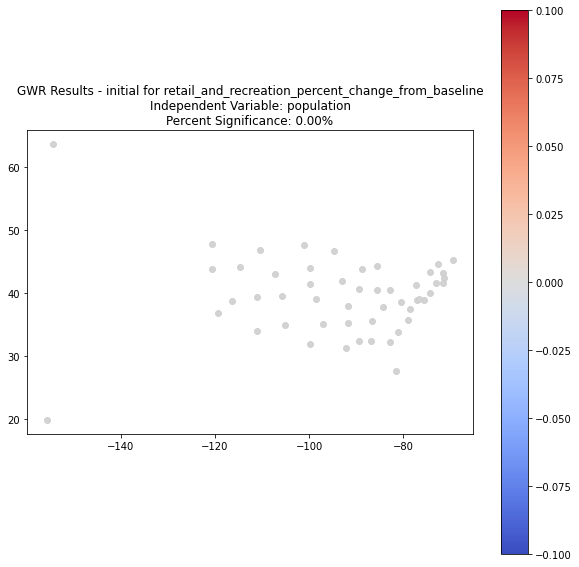

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - delta with popsqmi:
51 out of 51 data points are significant (100.00%).


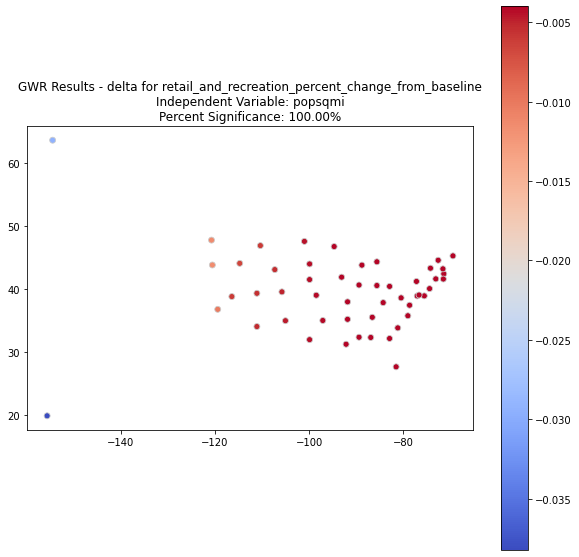

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For retail_and_recreation_percent_change_from_baseline - delta with population:
51 out of 51 data points are significant (100.00%).


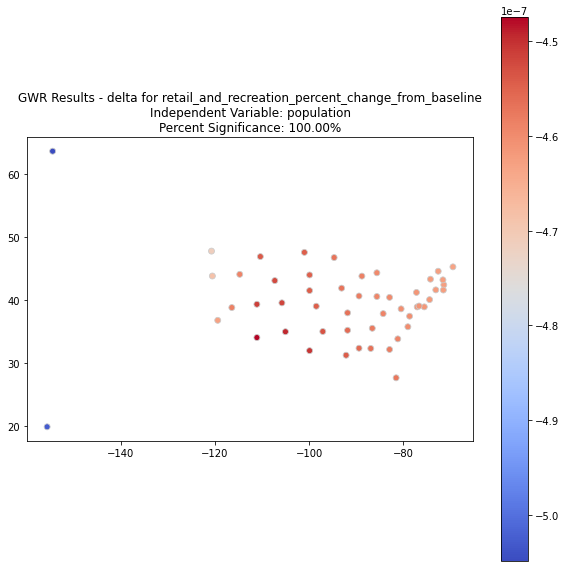

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - Qmax with popsqmi:
43 out of 51 data points are significant (84.31%).


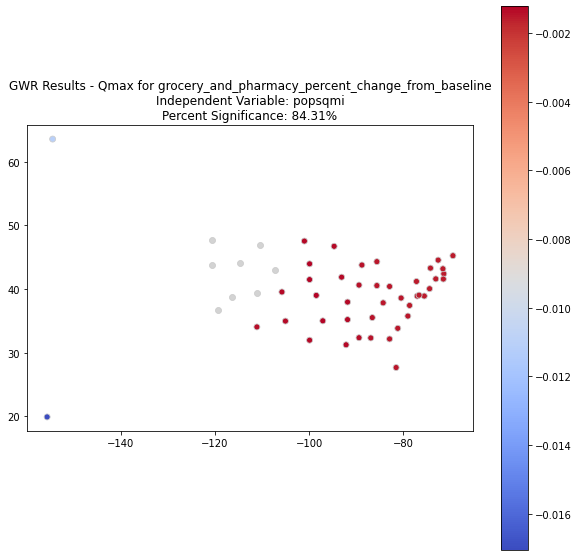

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - Qmax with population:
0 out of 51 data points are significant (0.00%).


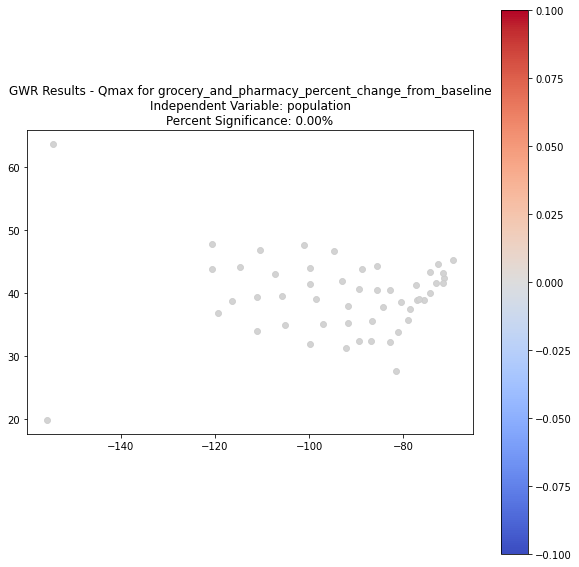

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - alpha with popsqmi:
43 out of 51 data points are significant (84.31%).


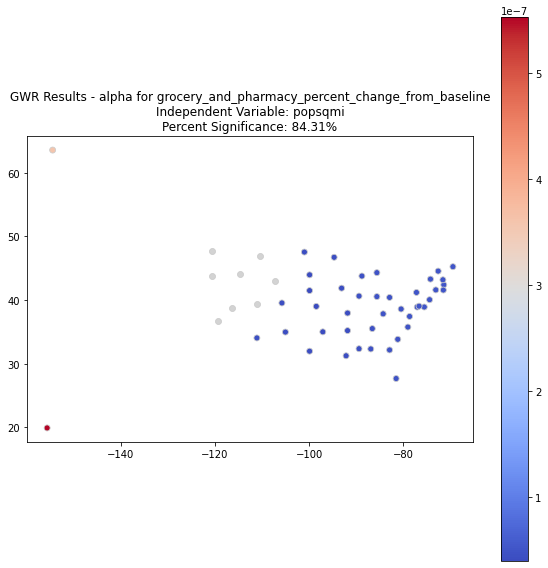

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - alpha with population:
0 out of 51 data points are significant (0.00%).


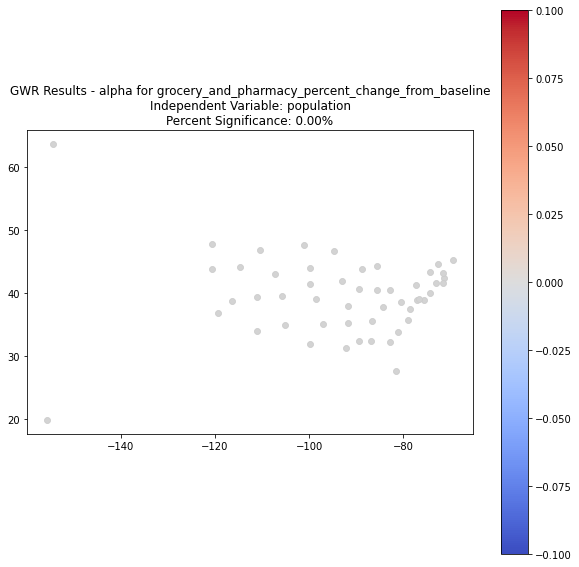

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - beta with popsqmi:
0 out of 51 data points are significant (0.00%).


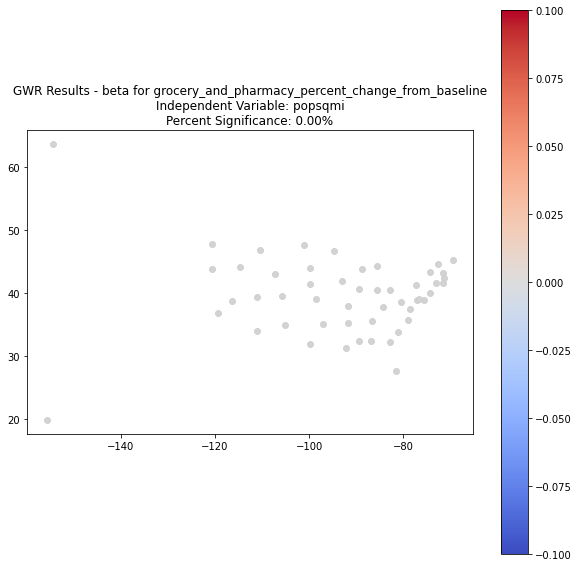

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - beta with population:
0 out of 51 data points are significant (0.00%).


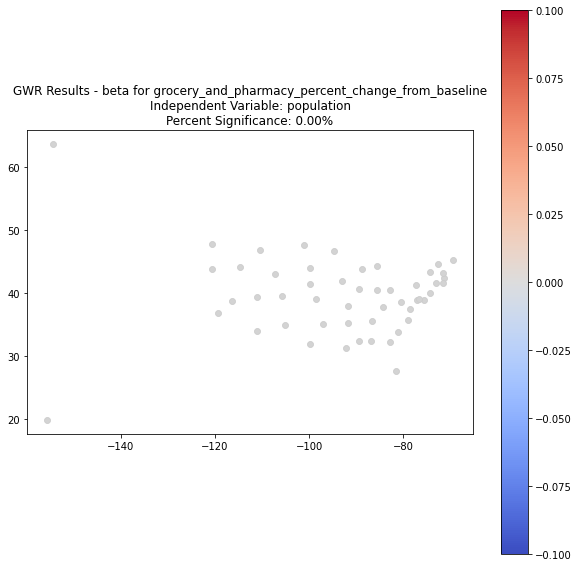

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - initial with popsqmi:
0 out of 51 data points are significant (0.00%).


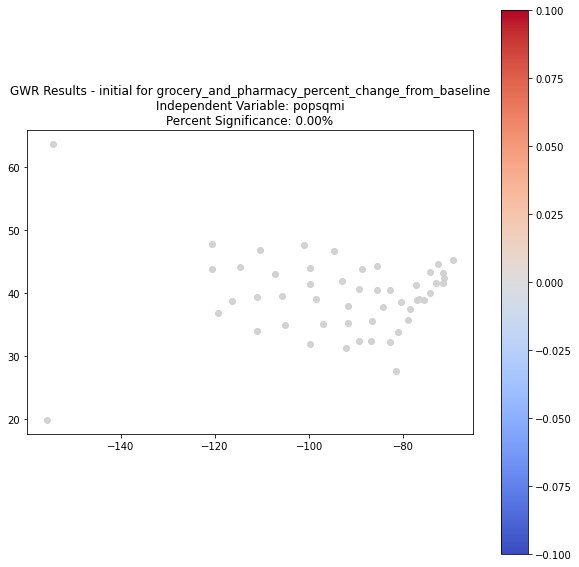

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - initial with population:
0 out of 51 data points are significant (0.00%).


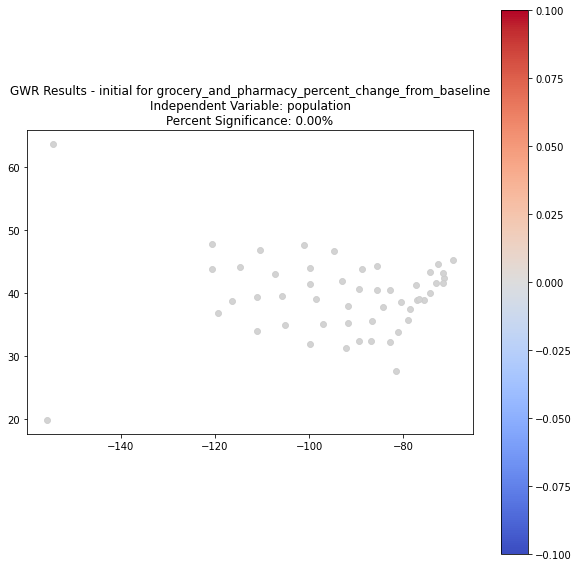

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - delta with popsqmi:
51 out of 51 data points are significant (100.00%).


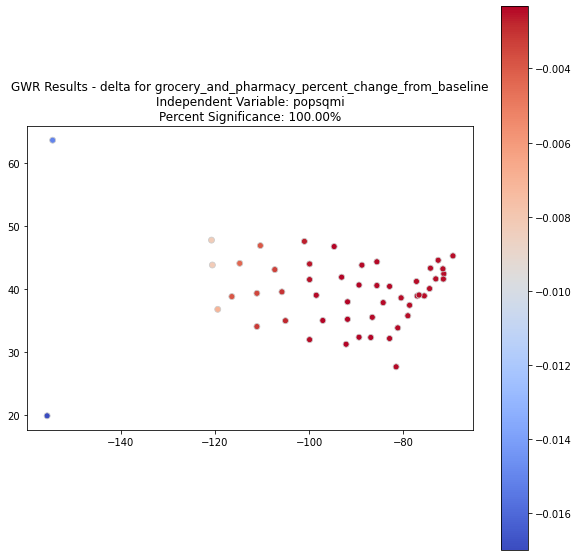

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For grocery_and_pharmacy_percent_change_from_baseline - delta with population:
50 out of 51 data points are significant (98.04%).


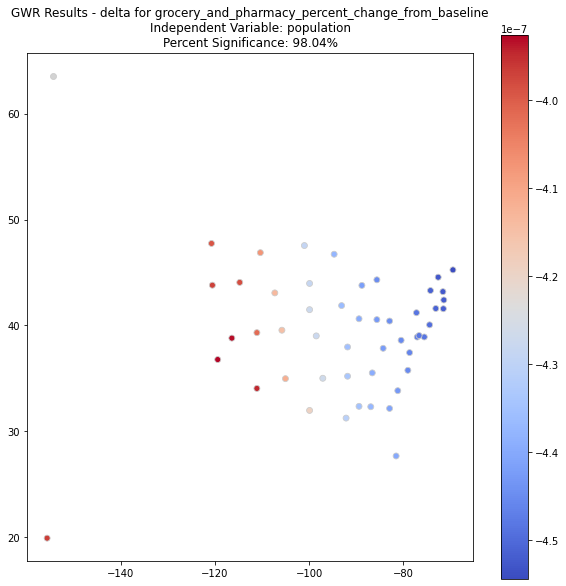

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - Qmax with popsqmi:
48 out of 51 data points are significant (94.12%).


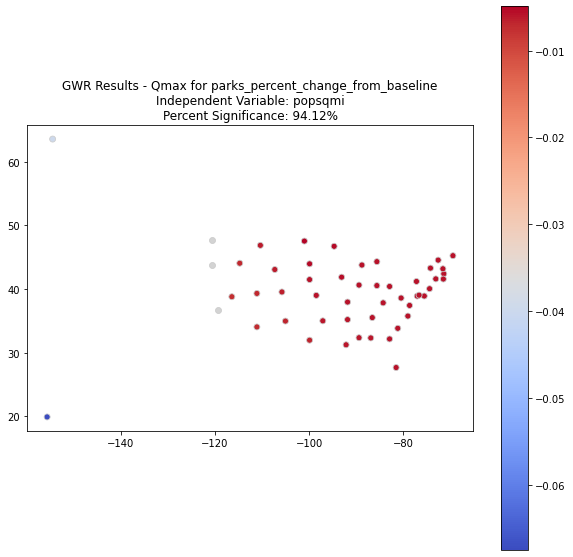

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - Qmax with population:
0 out of 51 data points are significant (0.00%).


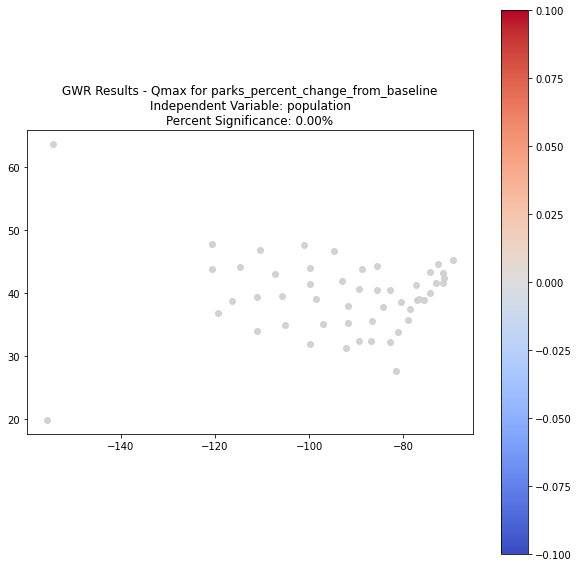

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - alpha with popsqmi:
48 out of 51 data points are significant (94.12%).


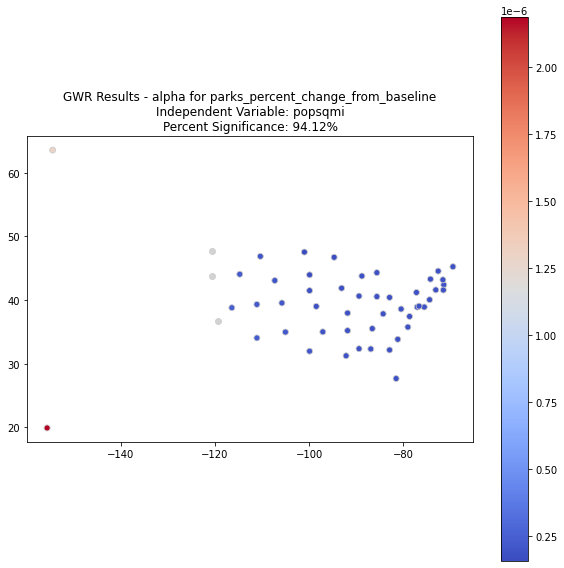

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - alpha with population:
0 out of 51 data points are significant (0.00%).


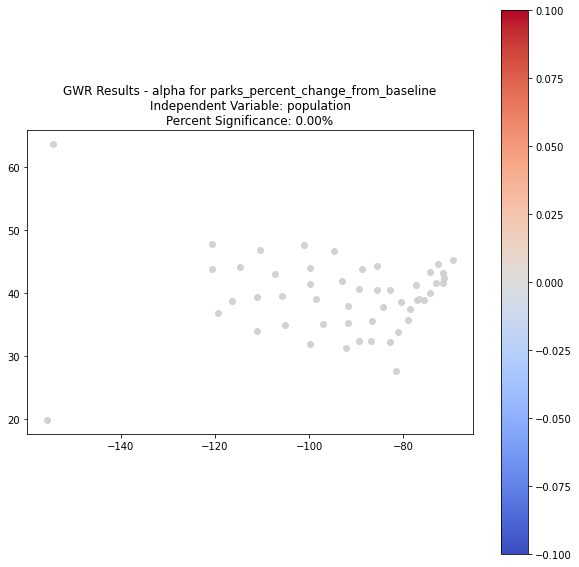

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - beta with popsqmi:
0 out of 51 data points are significant (0.00%).


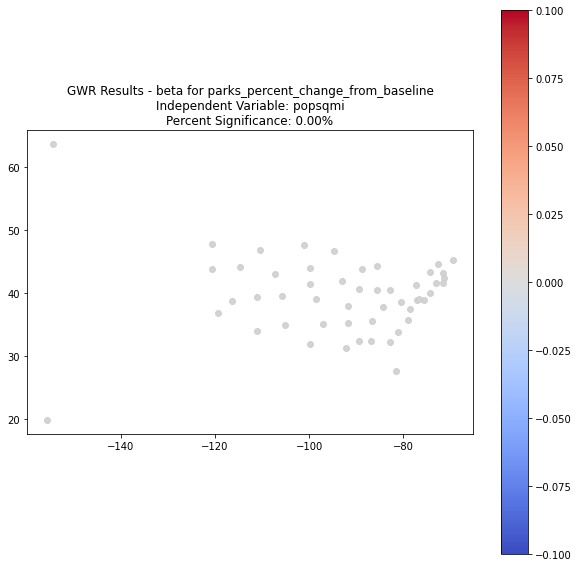

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - beta with population:
0 out of 51 data points are significant (0.00%).


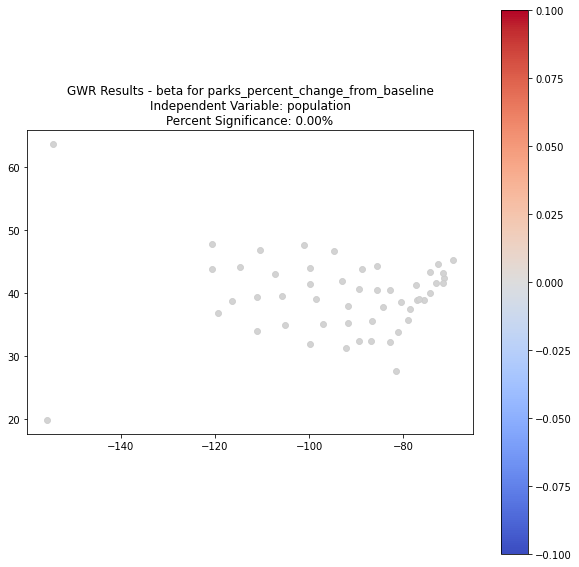

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - initial with popsqmi:
0 out of 51 data points are significant (0.00%).


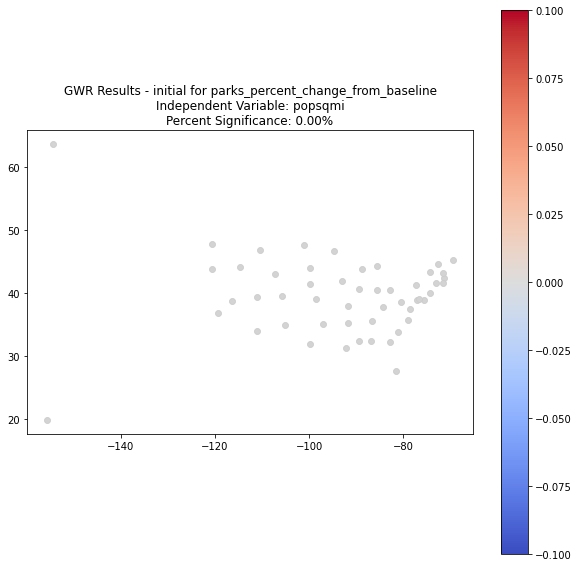

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - initial with population:
0 out of 51 data points are significant (0.00%).


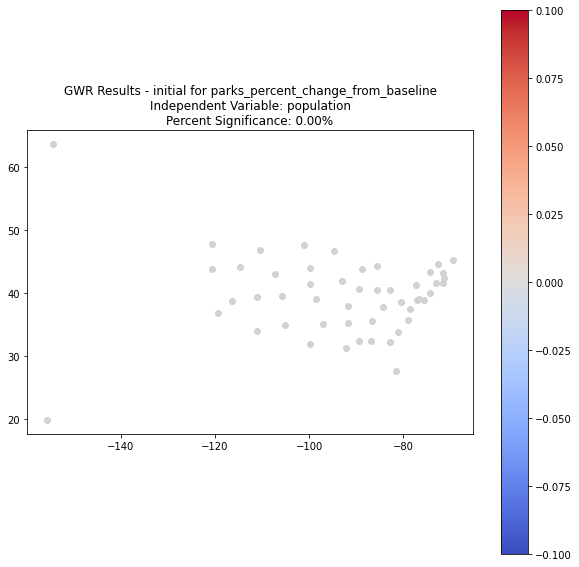

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - delta with popsqmi:
16 out of 51 data points are significant (31.37%).


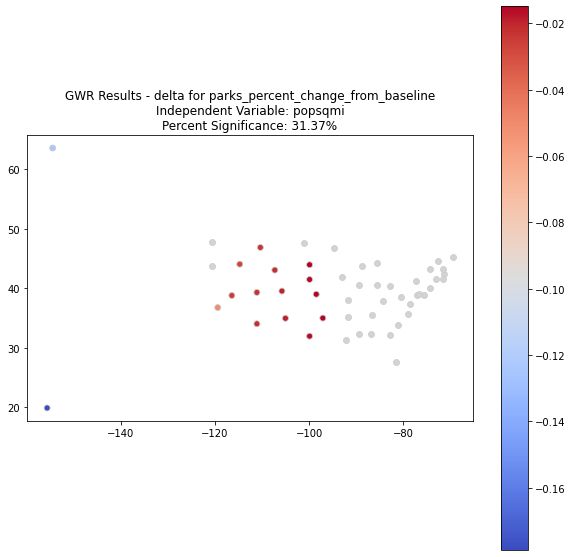

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For parks_percent_change_from_baseline - delta with population:
0 out of 51 data points are significant (0.00%).


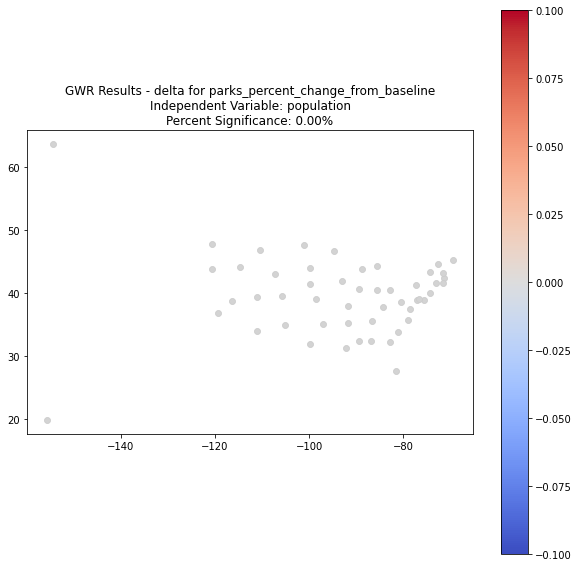

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - Qmax with popsqmi:
48 out of 51 data points are significant (94.12%).


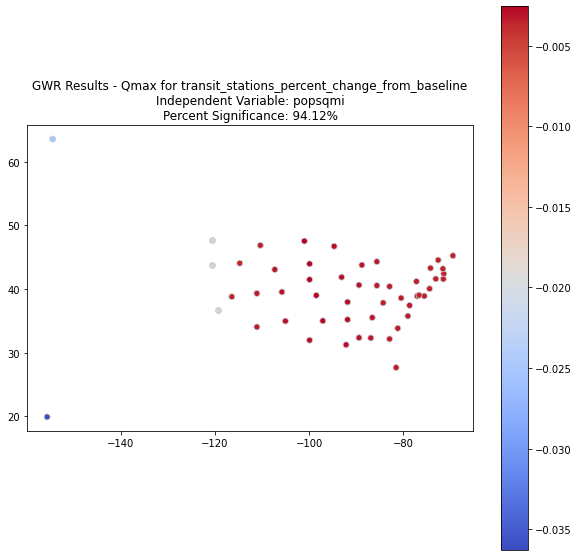

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - Qmax with population:
0 out of 51 data points are significant (0.00%).


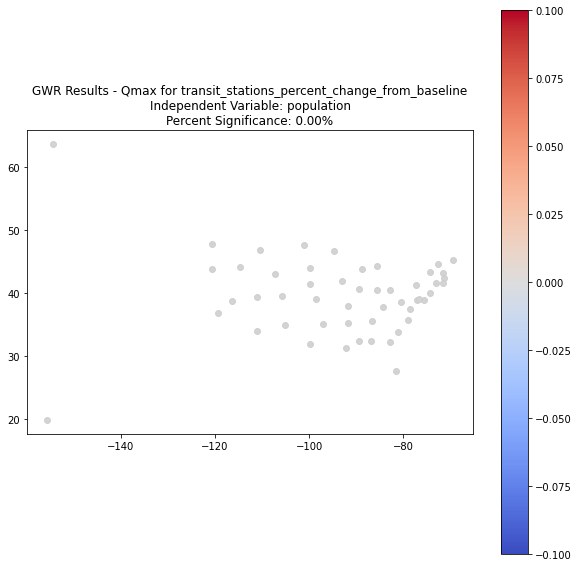

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - alpha with popsqmi:
48 out of 51 data points are significant (94.12%).


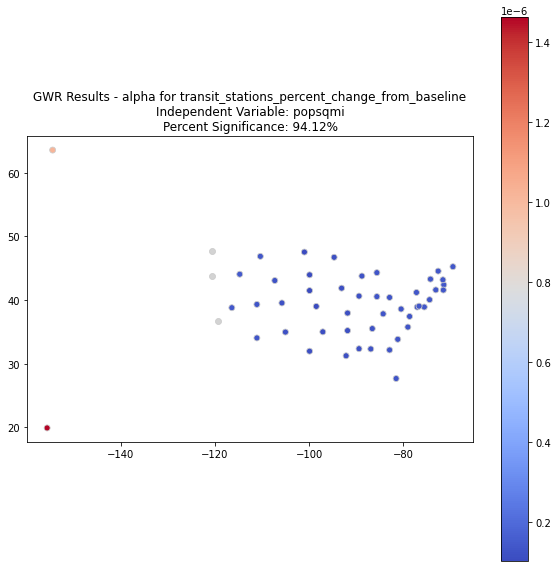

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - alpha with population:
0 out of 51 data points are significant (0.00%).


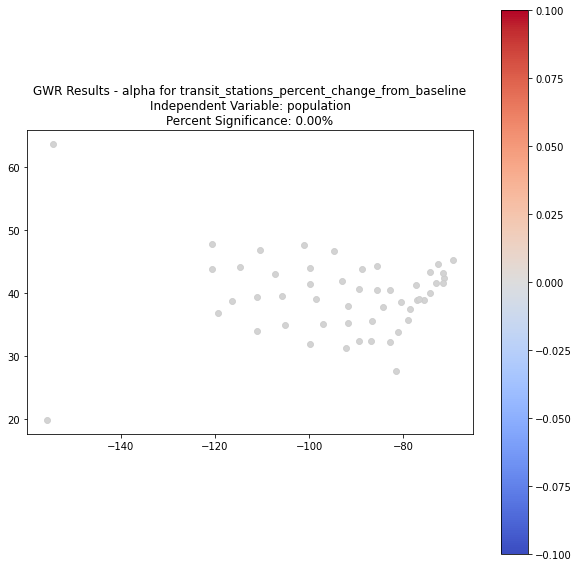

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - beta with popsqmi:
16 out of 51 data points are significant (31.37%).


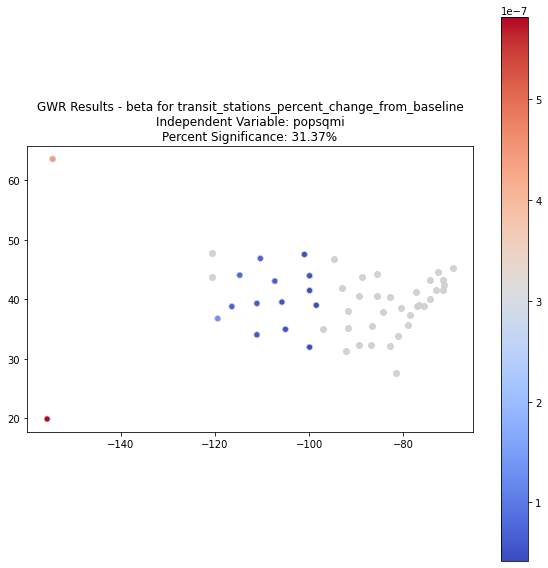

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - beta with population:
0 out of 51 data points are significant (0.00%).


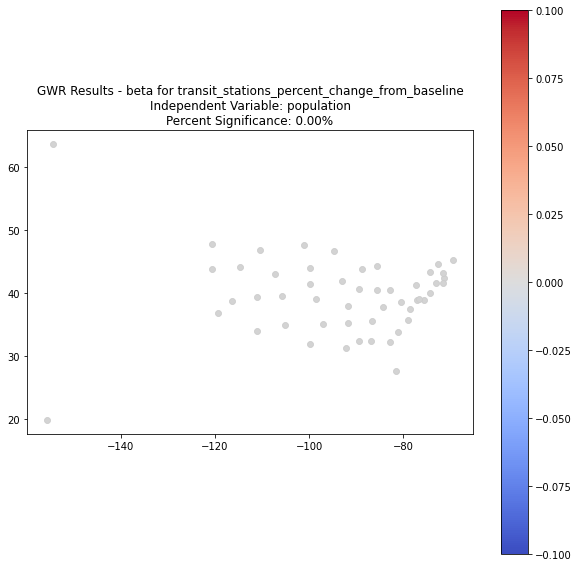

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - initial with popsqmi:
0 out of 51 data points are significant (0.00%).


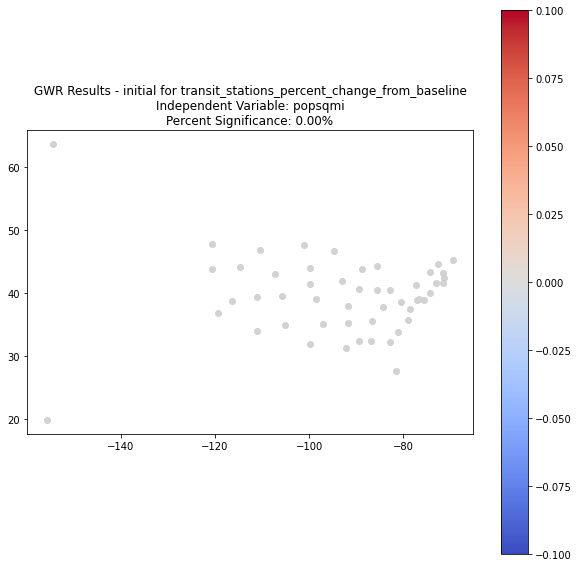

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - initial with population:
0 out of 51 data points are significant (0.00%).


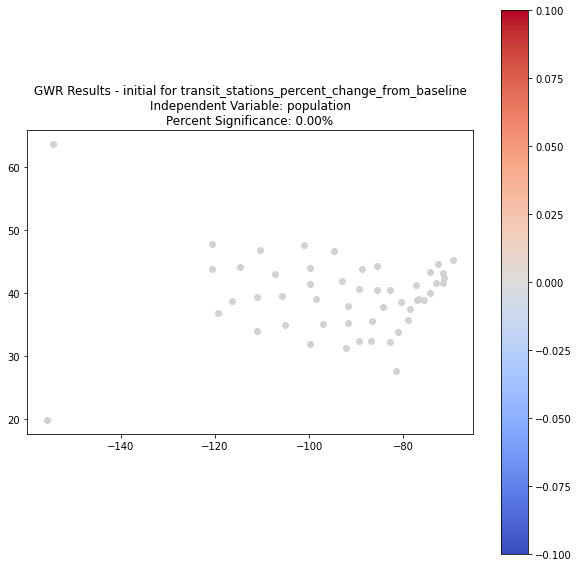

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - delta with popsqmi:
51 out of 51 data points are significant (100.00%).


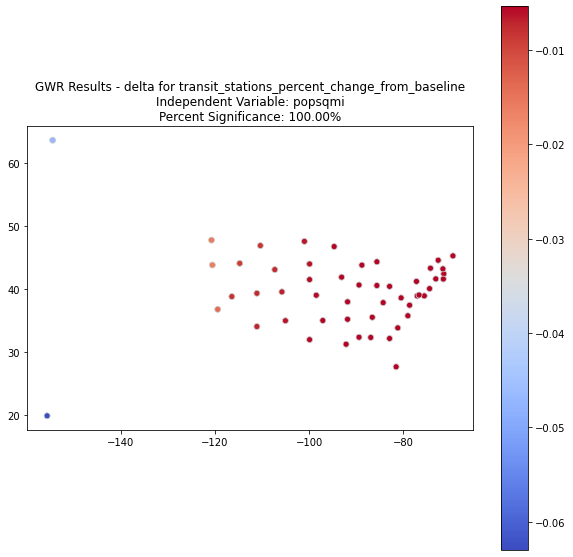

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For transit_stations_percent_change_from_baseline - delta with population:
0 out of 51 data points are significant (0.00%).


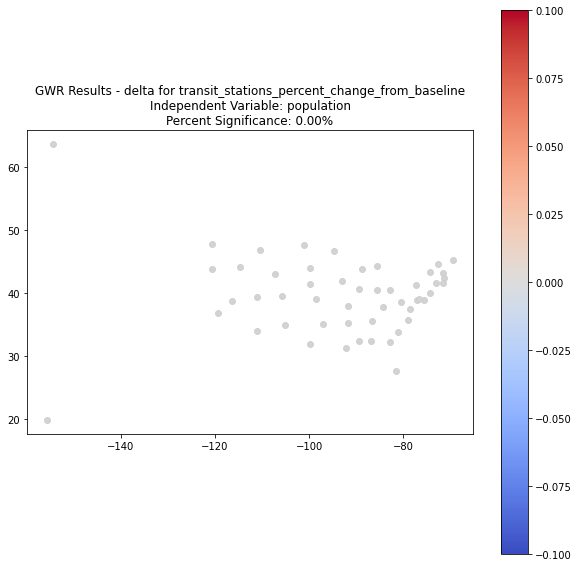

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - Qmax with popsqmi:
50 out of 51 data points are significant (98.04%).


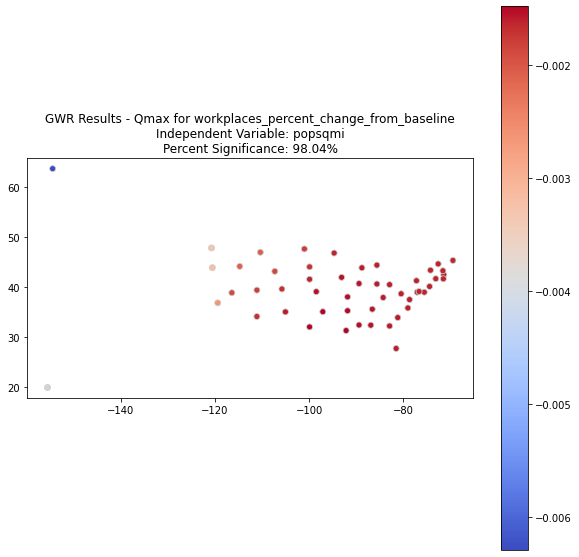

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - Qmax with population:
0 out of 51 data points are significant (0.00%).


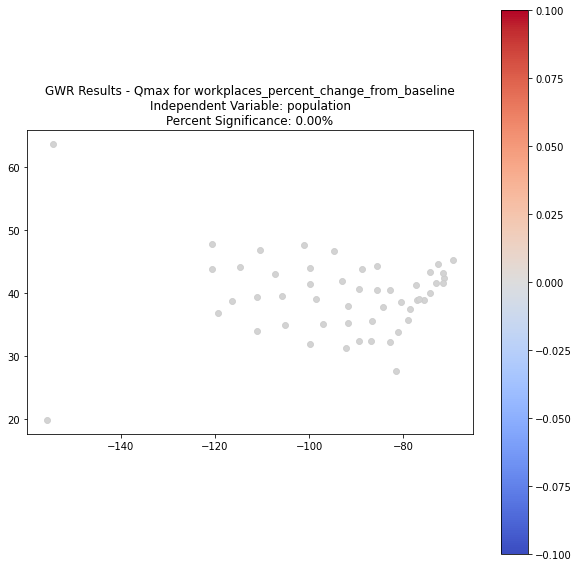

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - alpha with popsqmi:
50 out of 51 data points are significant (98.04%).


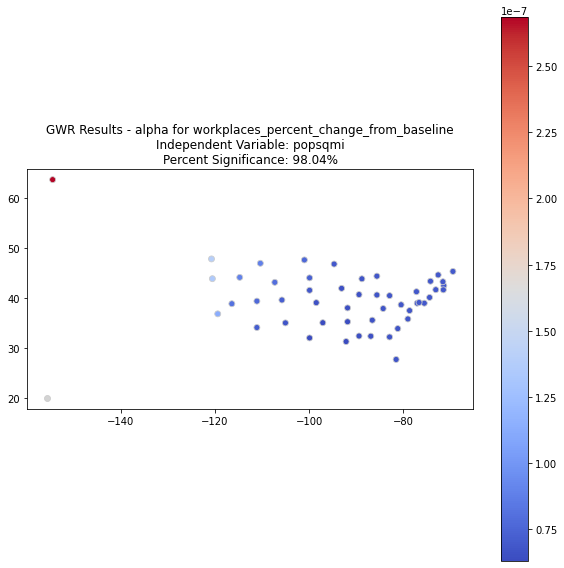

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - alpha with population:
0 out of 51 data points are significant (0.00%).


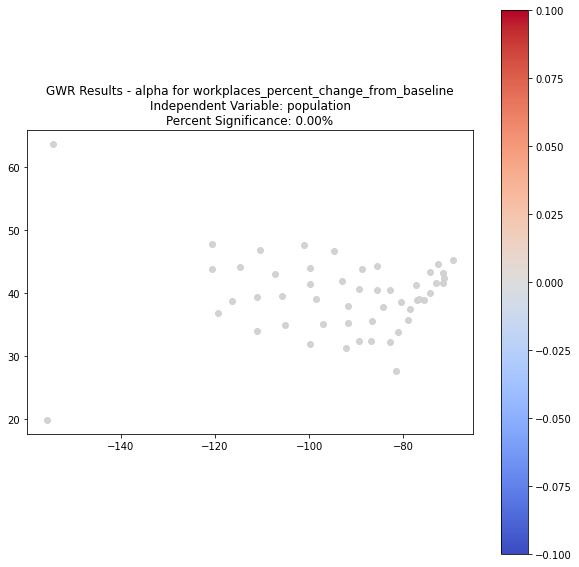

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - beta with popsqmi:
0 out of 51 data points are significant (0.00%).


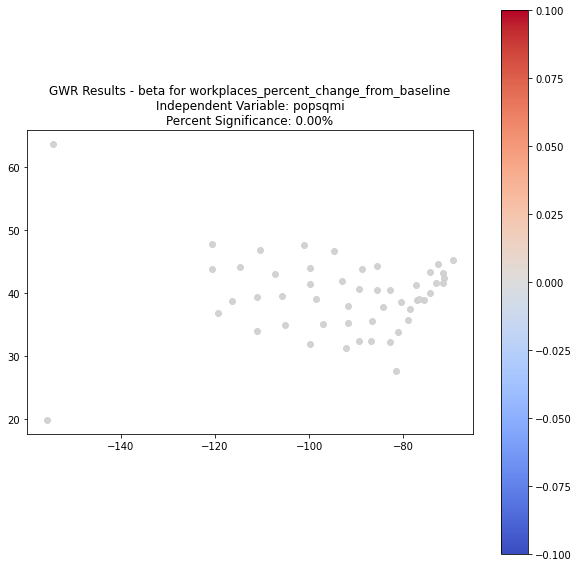

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - beta with population:
0 out of 51 data points are significant (0.00%).


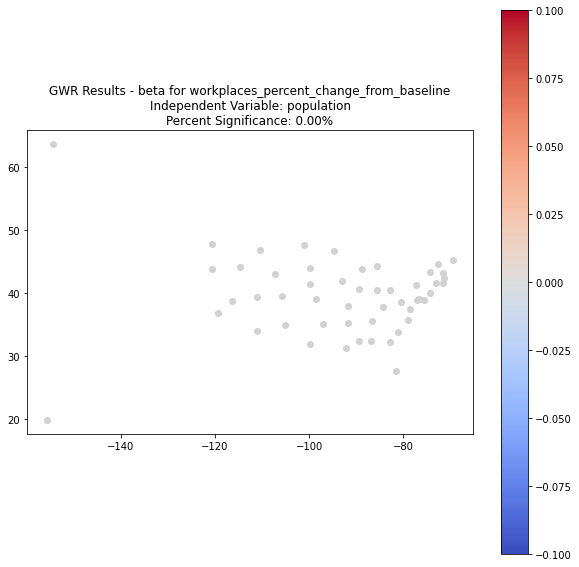

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - initial with popsqmi:
0 out of 51 data points are significant (0.00%).


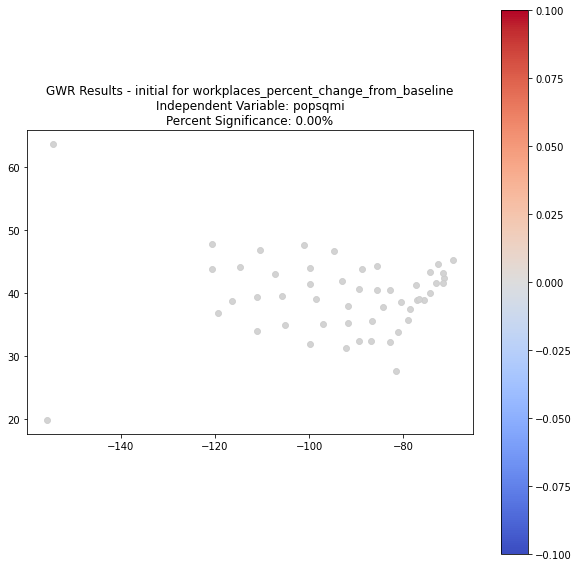

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - initial with population:
0 out of 51 data points are significant (0.00%).


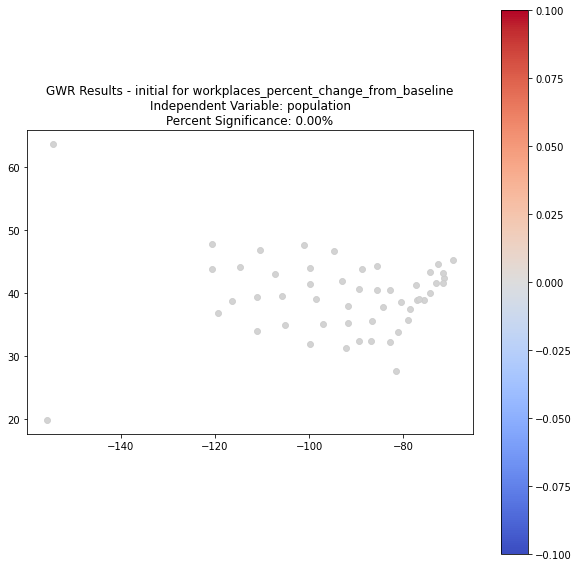

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - delta with popsqmi:
51 out of 51 data points are significant (100.00%).


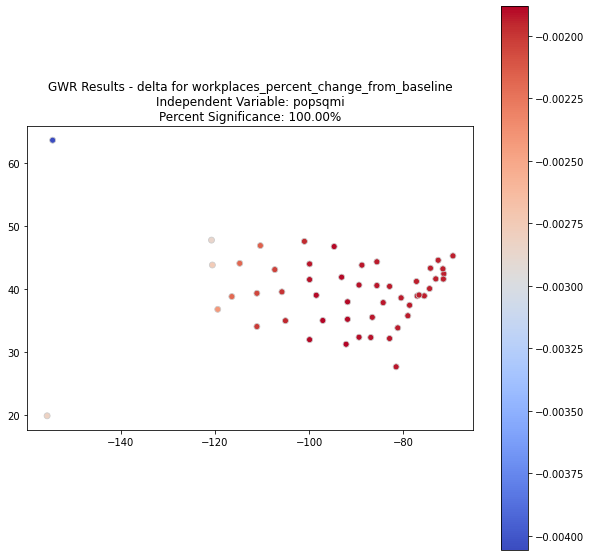

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For workplaces_percent_change_from_baseline - delta with population:
0 out of 51 data points are significant (0.00%).


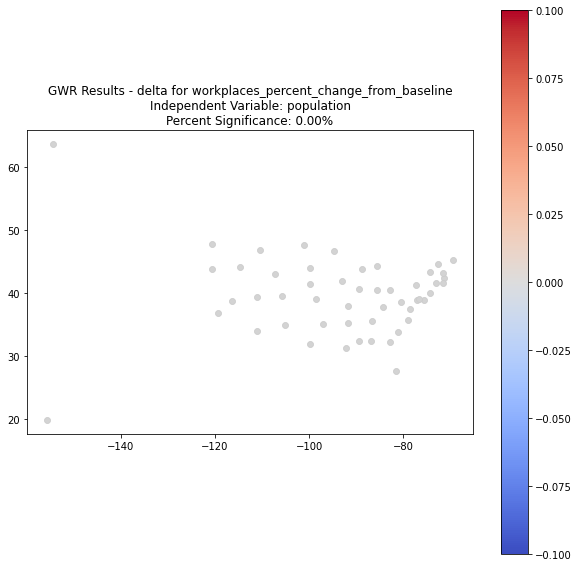

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - Qmax with popsqmi:
2 out of 51 data points are significant (3.92%).


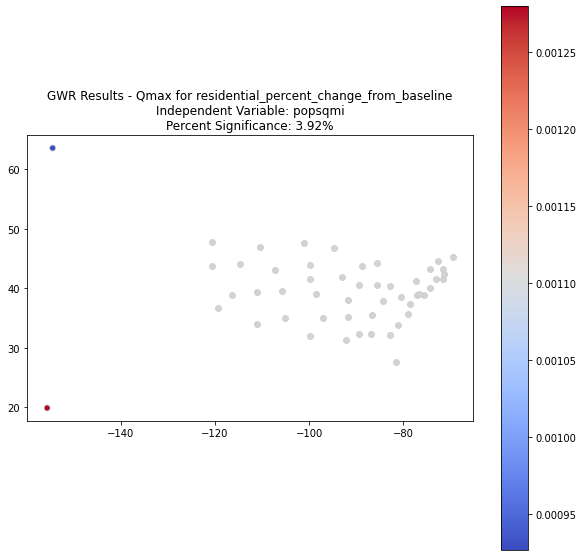

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - Qmax with population:
0 out of 51 data points are significant (0.00%).


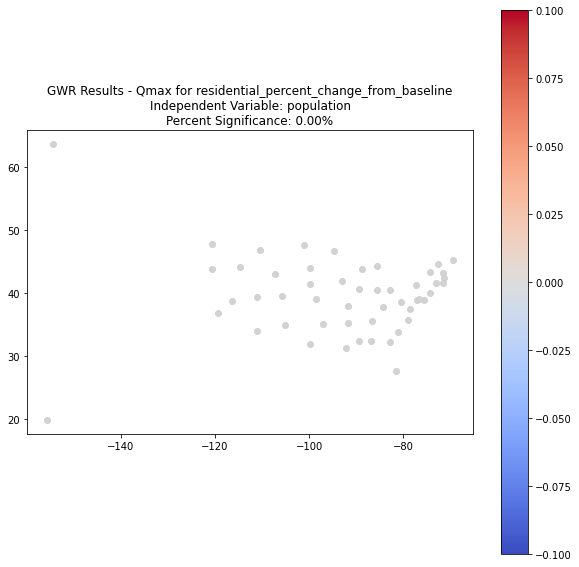

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - alpha with popsqmi:
2 out of 51 data points are significant (3.92%).


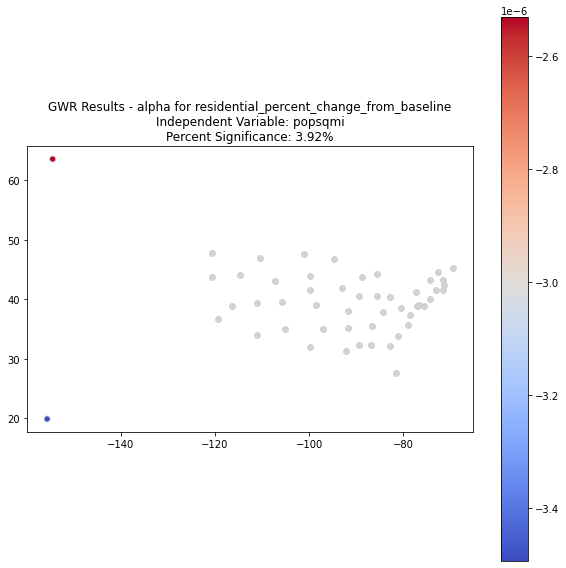

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - alpha with population:
0 out of 51 data points are significant (0.00%).


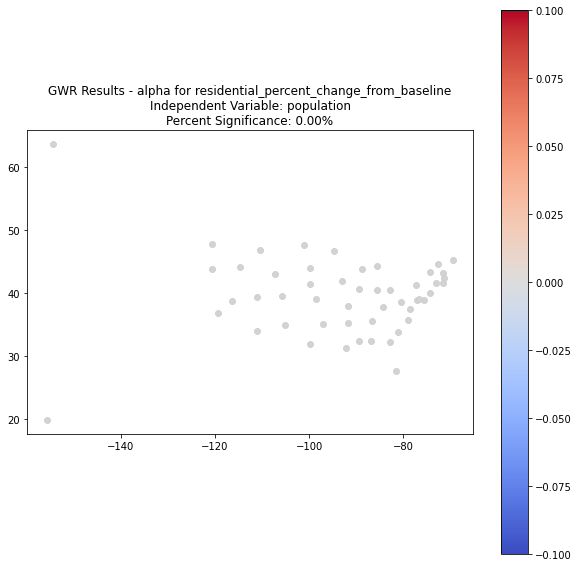

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - beta with popsqmi:
1 out of 51 data points are significant (1.96%).


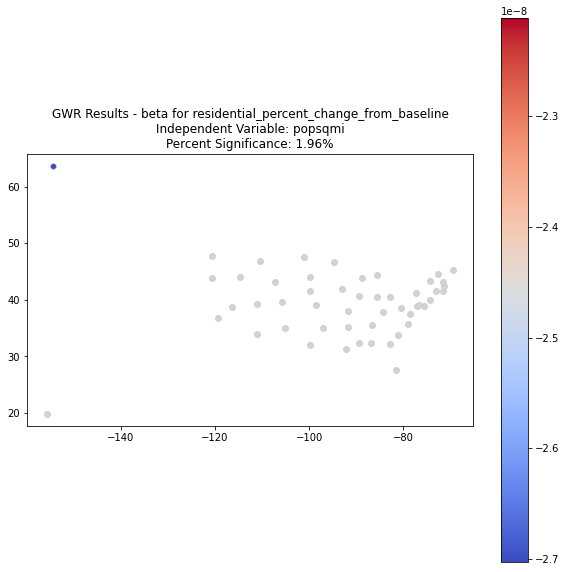

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - beta with population:
49 out of 51 data points are significant (96.08%).


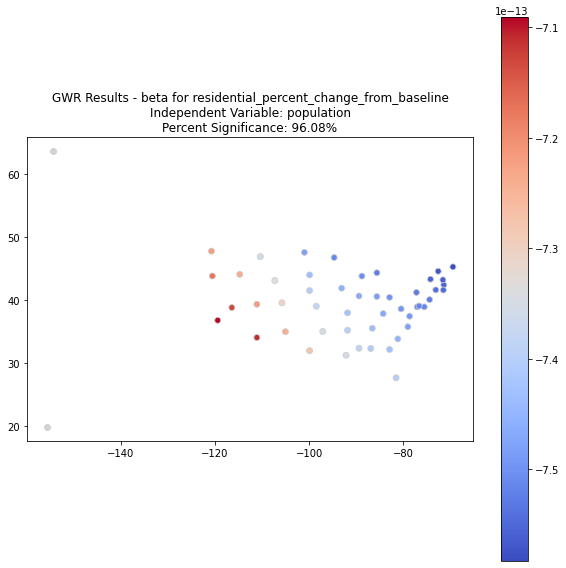

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - initial with popsqmi:
0 out of 51 data points are significant (0.00%).


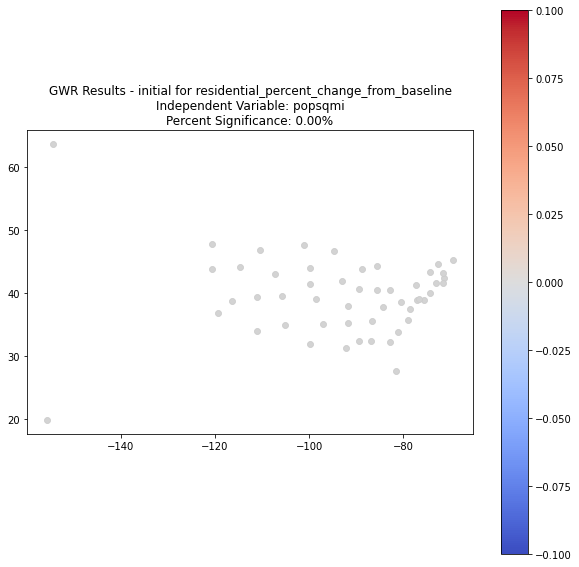

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - initial with population:
0 out of 51 data points are significant (0.00%).


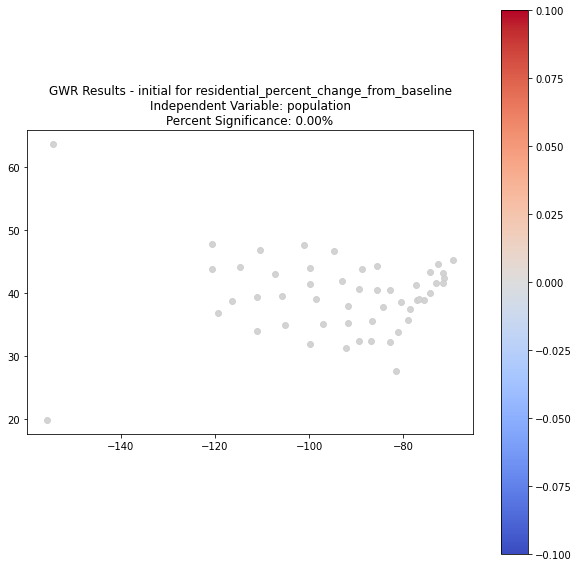

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - delta with popsqmi:
2 out of 51 data points are significant (3.92%).


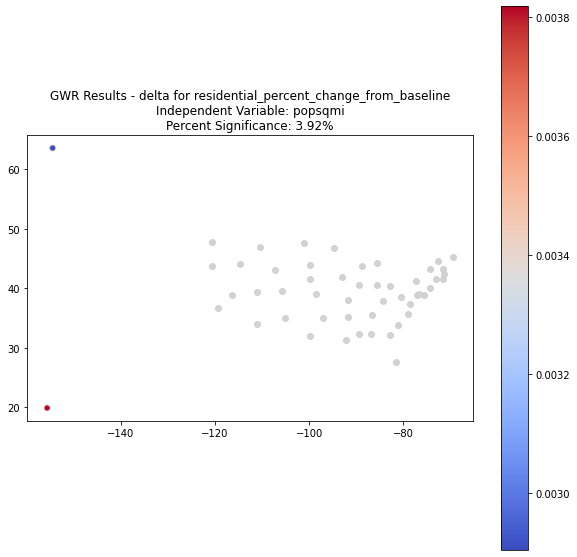

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

For residential_percent_change_from_baseline - delta with population:
50 out of 51 data points are significant (98.04%).


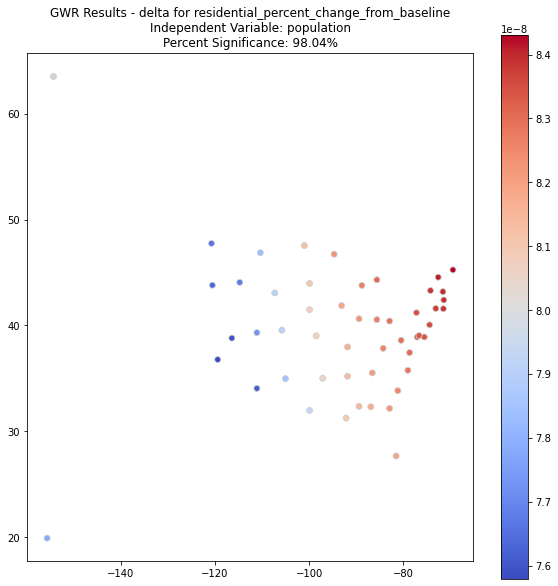

In [624]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from mgwr.gwr import MGWR
from mgwr.sel_bw import Sel_BW
from scipy.stats import t

# Read the CSV files
path_deviation = "../../ExportedData/DeviationDF.csv"
deviation_df = pd.read_csv(path_deviation)
path_centroids = "../../StateCentroids.csv"
centroids_df = pd.read_csv(path_centroids)
deviation_df.rename(columns={'state': 'name'}, inplace=True)
final_df = pd.merge(deviation_df, centroids_df, on='name', how='left')
final_df = final_df.dropna(subset=['latitude', 'longitude'])

# Create a GeoSeries from the latitude and longitude
geometry = [Point(xy) for xy in zip(final_df.longitude, final_df.latitude)]
final_gdf = gpd.GeoDataFrame(final_df, geometry=geometry)
final_gdf.crs = "EPSG:4326"

# Extract unique mobility types
mobility_types = final_df['mobility_type'].unique()

# List of dependent variables
dependent_variables = ['Qmax', 'alpha', 'beta', 'initial', 'delta']

# List of independent variables
independent_variables = ['popsqmi', 'population']

# DataFrame to store coefficients
coefficients_df = pd.DataFrame()

for mobility_type in mobility_types:
    df_filtered = final_gdf[final_gdf['mobility_type'] == mobility_type]

    for dependent_variable in dependent_variables:
        for independent_var in independent_variables:
            X = df_filtered[[independent_var]].values
            y = df_filtered[[dependent_variable]].values
            sel_bw = Sel_BW(coords, y, X, multi=True)
            bw = sel_bw.search()
            model = MGWR(coords, y, X, sel_bw)
            results = model.fit()

            t_values = results.filter_tvals()
            n_observations = len(df_filtered)
            degrees_of_freedom = n_observations - 2
            critical_t_value = t.ppf(0.95, degrees_of_freedom)

            # Determine significant rows
            significant_rows = np.abs(t_values[:, 1]) > critical_t_value

            # Create a new series with significant values, and set non-significant values to NaN
            plot_values = np.where(
                significant_rows, results.params[:, 1], np.nan)

            # Calculate percentage and number of significant data points
            num_significant = significant_rows.sum()
            percent_significance = (num_significant / n_observations) * 100

            print(
                f"For {mobility_type} - {dependent_variable} with {independent_var}:")
            print(
                f"{num_significant} out of {n_observations} data points are significant ({percent_significance:.2f}%).")

            # Add the coefficients to the coefficients DataFrame
            coefficients_df = coefficients_df.append(pd.DataFrame({
                'mobility_type': mobility_type,
                'dependent_variable': dependent_variable,
                'independent_variable': independent_var,
                'coefficients': results.params[:, 1]
            }))

            # Plot
            fig, ax = plt.subplots(figsize=(10, 10))
            df_filtered['plot_values'] = plot_values
            df_filtered.plot(column='plot_values', cmap='coolwarm', linewidth=0.8,
                             ax=ax, edgecolor='0.8', legend=True, missing_kwds={'color': 'lightgrey'})
            plt.title(
                f'GWR Results - {dependent_variable} for {mobility_type}\nIndependent Variable: {independent_var}\nPercent Significance: {percent_significance:.2f}%')
            filename = f"Charts_png/{mobility_type}_{dependent_variable}_{independent_var}.png"

            # Save the plot to a PNG file
            plt.savefig(filename)
            plt.show()

# Export the coefficients to a CSV file
coefficients_df.to_csv('regression_coefficients.csv', index=False)
